## Import dependencies

In [ ]:
# !pip install wurlitzer
# !pip install tensorflow_decision_forests
# !pip install transformers
!pip install tensorflow_text

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import re
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity as csim
import seaborn as sns
# import tensorflow_decision_forests as tfdf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Dec 13 17:40:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Import data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/GeoData_Extraction/geo_data_full.csv')
df

,message_id,date,text,source,geom,longitude,latittude,place_name
0,1156716420803235846,2019-08-01 00:01:00,Drinking an Anti-Hero by @revbrewchicago at @w...,Untapped,0101000020E61000006ADE718A8EE855C0A779C7293AEA...,-87.633700,41.829900,"('Chicago', 'US')"
1,1156717020605538305,2019-08-01 00:03:23,"Finished the Bar!... well, our friend did. (at...",Foursquare,0101000020E6100000A66F046FE99E54C0444BA2876FEE...,-82.482998,27.931389,"('Tampa', 'US')"
2,1156717416170295298,2019-08-01 00:04:57,Want to put your data and organization at risk...,Instagram,0101000020E61000008F368E588B4B5EC0E6E8F17B9B22...,-121.180380,44.270370,"('Redmond', 'US')"
3,1156717868417015808,2019-08-01 00:06:45,I'm at Ro Chillin On Patio-smoke Break in Musc...,fswarm,0101000020E6100000158BDF1456E855C01407D0EFFB5D...,-87.630254,34.734251,"('Muscle Shoals', 'US')"
4,1156717978685181958,2019-08-01 00:07:11,"Just posted a photo @ Howland Township, Trumbu...",Instagram,0101000020E610000010B077FB833054C0A54B41AF269E...,-80.758056,41.235556,"('', 'US')"
...,...,...,...,...,...,...,...,...
133572,1266880019420385280,2020-05-30 23:51:48,“Karma” what goes around comes around \nPerfor...,Instagram,0101000020E61000000384E6A5281955C04C36FD5D48E1...,-84.393106,33.760021,"(None, None)"
133573,1266880300870705152,2020-05-30 23:52:55,Tough start for my transition to YouTube Music...,Instagram,0101000020E6100000A52C431CEBCE56C0B98D06F016E8...,-91.233100,43.813200,"(None, None)"
133574,1266880799145672704,2020-05-30 23:54:54,Week-end at home with Wendy and Adam!👪❤️⛱ @ Su...,Instagram,0101000020E6100000807F4A95283D5DC04DD9E90775F8...,-116.955602,33.941071,"(None, None)"
133575,1266881480581476352,2020-05-30 23:57:37,A lucky tweener gets a big boy room! This smal...,Instagram,0101000020E61000005C77F354872652C09A5FCD0182D5...,-72.602010,41.668030,"(None, None)"


In [ ]:
df = df[df.text.apply(len)>3].reset_index().drop(['index'], 1)

In [ ]:
# Preprocessing to get the place_names and remove country name as the country is same for the whole dataset
def fun(x):
    for num,i in enumerate(x):
        if i == ',':
            return num-1
def findi(x):
    for num, i in enumerate(x):
        if i.isalnum():
            return num
    return 0
new_df = df[df['place_name'].apply(lambda x: x[findi(x):fun(x)])!=''].reset_index()
new_df['place_name'] = new_df['place_name'].apply(lambda x: x[findi(x):fun(x)])
new_df = new_df[new_df['place_name']!='Non'].reset_index()
new_df = new_df.drop(['level_0', 'index'], axis=1)

In [ ]:
X = new_df['text']
y = new_df['place_name']
X = X.apply(lambda x: re.sub('[^0-9a-zA-Z@# ]+', '', x)).apply(lambda x: re.sub('\\s+', ' ', x))

## Classes for number of samples between begin and end

In [ ]:
begin = 200 # @param {type:"slider", min:0, max:13347, step:100}
end = 600 # @param {type:"slider", min:100, max:13357, step:100}

In [ ]:
z = y.value_counts()[new_df['place_name']]
z

Chicago          1229
Tampa             257
Redmond            20
Muscle Shoals      30
Silver Spring      30
                 ... 
Tappahannock        1
Norwalk            49
Livonia            11
Los Angeles      2980
New York         4979
Name: place_name, Length: 57998, dtype: int64

In [ ]:
# new_df.info()

In [ ]:
new_df = new_df.join(pd.DataFrame({'z-axis':[k for k in z]}))

In [ ]:
conditions = new_df[new_df['z-axis']>begin]
conditions = conditions[conditions['z-axis']<end]
new_df = conditions.reset_index().drop(['index'], axis=1)
# new_df

In [ ]:
X[0], y[0]

('Drinking an AntiHero by @revbrewchicago at @whitesox httpstcofaeyUoClHU',
 'Chicago')

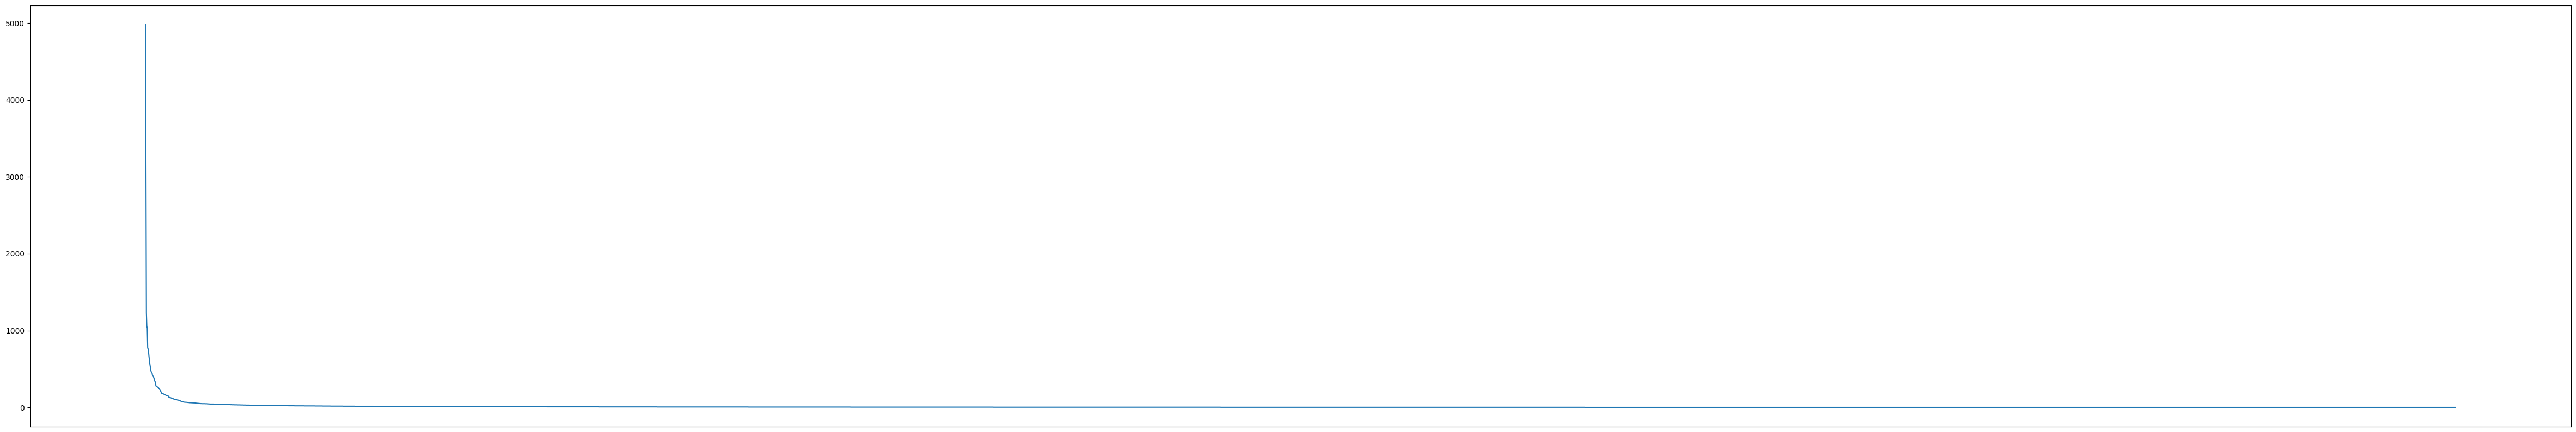

In [ ]:
plt.plot(y.value_counts())
plt.xticks([]);

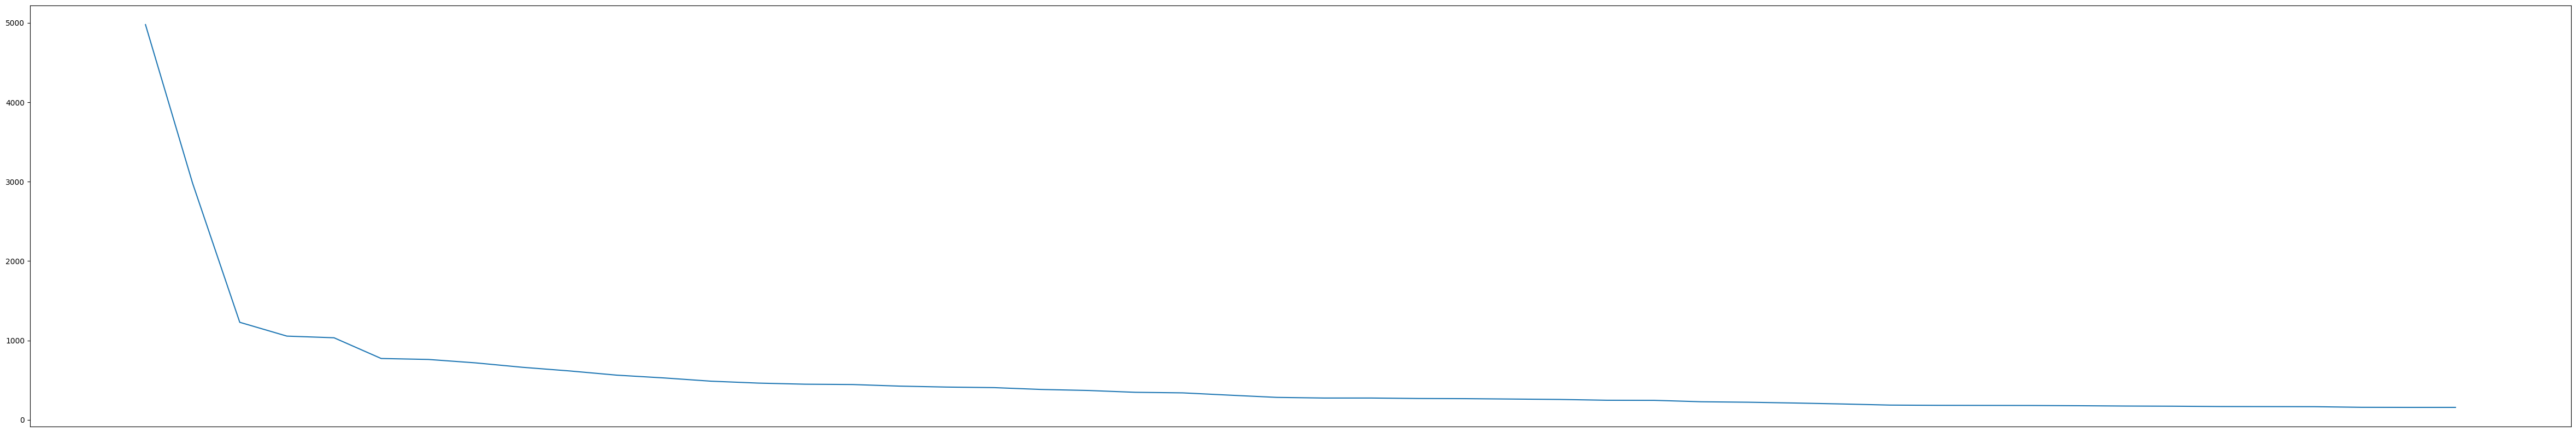

In [ ]:
plt.plot(y.value_counts()[:50])
plt.xticks([]);

In [ ]:
y.value_counts()['Atlanta']

1034

In [ ]:
import tensorflow_text as text # Registers the ops.

In [ ]:
X[4], y[4]

('Stopped by to see my record guy at @proteanbooks after work today and loaded up on some classics I spent all of my allowance You gotta say I have some eclectic tastes #b52s #depechemode #speakandspell httpstcomIUHFnE13e',
 'Silver Spring')

In [ ]:
# y_preds = [get_locations(i) for i in X[:10]]

In [ ]:
# y_preds

In [ ]:
y.shape, y.unique().shape

((57998,), (5303,))

## X-y split

```
Train_TEST_Split
```

In [ ]:
X = new_df['text']
y = new_df['place_name']

X = X.apply(lambda x: re.sub('[^0-9a-zA-Z@# ]+', '', x)).apply(lambda x: re.sub('\\s+', ' ', x))
y = y.apply(lambda x: re.sub('[^0-9a-zA-Z@# ]+', '', x)).apply(lambda x: re.sub('\\s+', ' ', x))

In [ ]:
# Load model directly
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

# Preprocessing

## For Binary representation preprocessing

In [ ]:
# def encode_place_name(place_name):
#   place_name = place_name.lower()

#   for val in y.unique():
#     if val.lower() == place_name:
#       return y_uniq[place_name]
#   k_str = format(0, f'0{BIN_LEN}b')
#   return[int(i) for i in k_str]

# encode_place_name('Chicago'), encode_place_name('Delhi')

In [ ]:
BIN_LEN = 18
y_uniq = {}
for num, val in enumerate(y.unique()):
  val = val.lower()
  y_uniq[val] = format(num+1, f'0{BIN_LEN}b')
  y_uniq[val] = [int(i) for i in y_uniq[val]]
len(y_uniq)

26

## Encoder loading

In [ ]:
# Tokenize the input statements
tf_hub_token_embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                    trainable=False,
                                    name="tf_hub_trainable_embedding_layer")

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity as csim
print(
    csim(tf_hub_token_embed(['I am in Chicago today']),
     tf_hub_token_embed(['I am in Ch1cago running some errands'])),
    csim(tf_hub_token_embed(['I will be in Chicago tomorrow']),
        tf_hub_token_embed(['I was at Ch1cago yesterday']))
)

[[0.31912065]] [[0.34587908]]


## Self-evaluation function for binary representation of places

In [ ]:
# BIN_LEN = 18
# # Evaluation Metrics
# def eval_metrics(y_true, y_pred):
#   y_pred = tf.round(y_pred)
#   pred_results = tf.reduce_sum(
#       tf.cast(tf.reverse(tensor=y_pred, axis=[-1]), dtype=tf.int64)
#       * 2 ** tf.range(tf.cast(BIN_LEN, dtype=tf.int64)), axis=-1)

#   y_true = tf.round(y_true)
#   true_results = tf.reduce_sum(
#       tf.cast(tf.reverse(tensor=y_true, axis=[-1]), dtype=tf.int64)
#       * 2 ** tf.range(tf.cast(BIN_LEN, dtype=tf.int64)), axis=-1)

#   return tf.reduce_mean(tf.abs(pred_results - true_results))

## One-hot Encoding Representation

```
Database mapping from representation to places and vice-versa
```

In [ ]:
db_keys = y.unique().tolist()
db_values = range(1, len(y.unique())+1, 1)
db = dict(zip(db_keys, db_values))
db1 = dict(zip(db_values, db_keys))

In [ ]:
y_one_hot = np.zeros(shape=(len(y), len(y.unique())))

In [ ]:
for i in range(len(y)):
  y_one_hot[i, db[y[i]]-1] = 1.0
y_one_hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
tf_one_hot = tf.constant(y_one_hot)
tf_one_hot.shape

TensorShape([8973, 26])

In [ ]:
y_one_hot[:1]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
# y_one_hot_1 = np.array(y_one_hot)
# y_one_hot_1[y_one_hot == 0] = -1
# y_one_hot_1[y_one_hot == 1] = 0
# y_one_hot_1[y_one_hot_1 < 0] = 1
# y_one_hot_1

In [ ]:
# new_y_one_hot = np.concatenate((y_one_hot, y_one_hot_1), axis=-1)

## Train-test-split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_one_hot,
                                                    # np.array([encode_place_name(j) for j in y]),
                                                    test_size=0.4, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5383,), (5383, 26), (3590,), (3590, 26))

In [ ]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test,
                                                    y_test,
                                                    # np.array([encode_place_name(j) for j in y]),
                                                    test_size=0.5, random_state=42)
X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((1795,), (1795, 26), (1795,), (1795, 26))

## Data Distribution

### Training data distribution

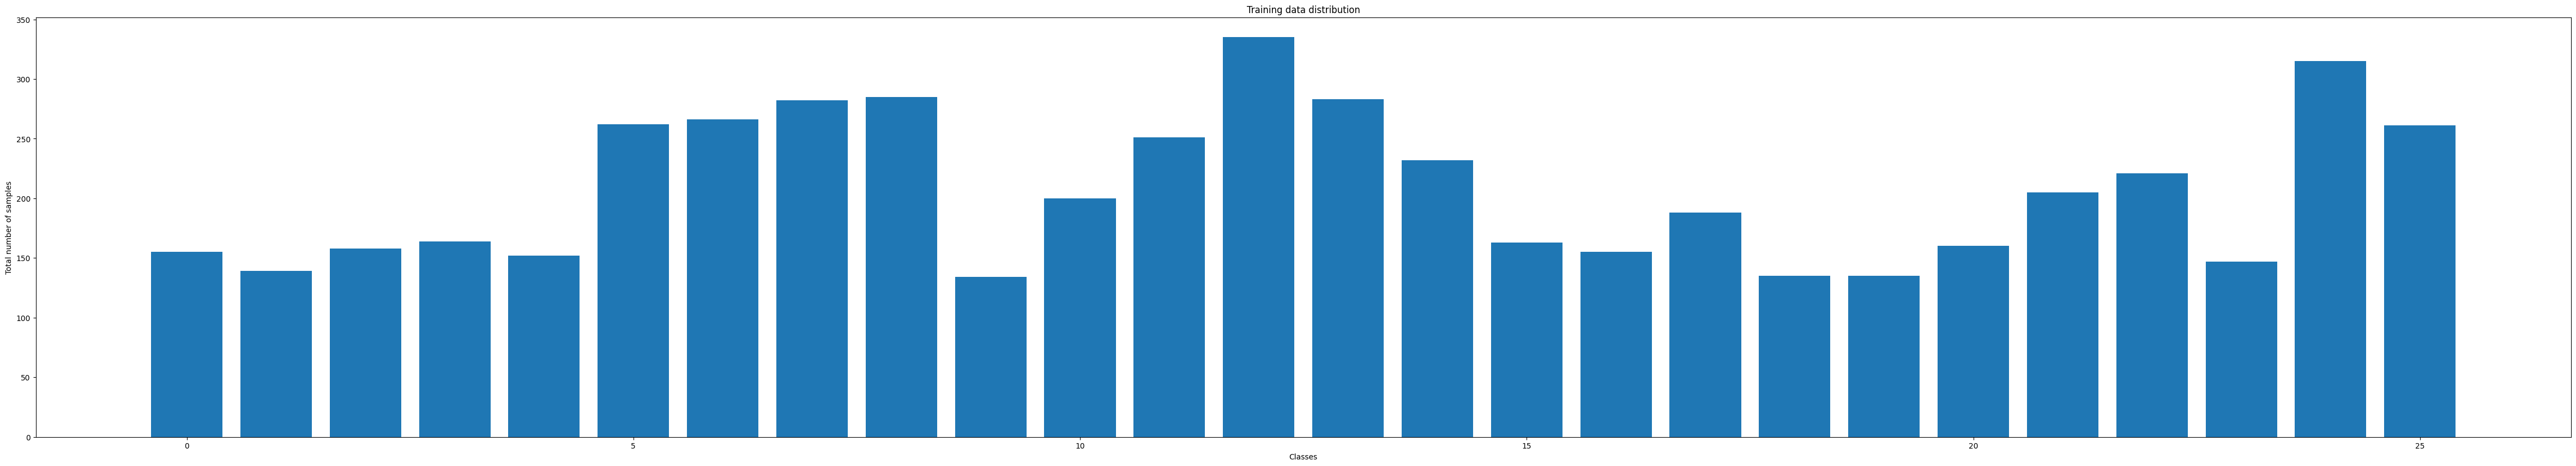

In [ ]:
XX, yy =np.unique(np.argmax(y_train, axis=-1), return_counts=True)
plt.xlabel('Classes')
plt.ylabel('Total number of samples')
plt.title('Training data distribution')
plt.bar(XX, yy);

### Validation Data Distribution

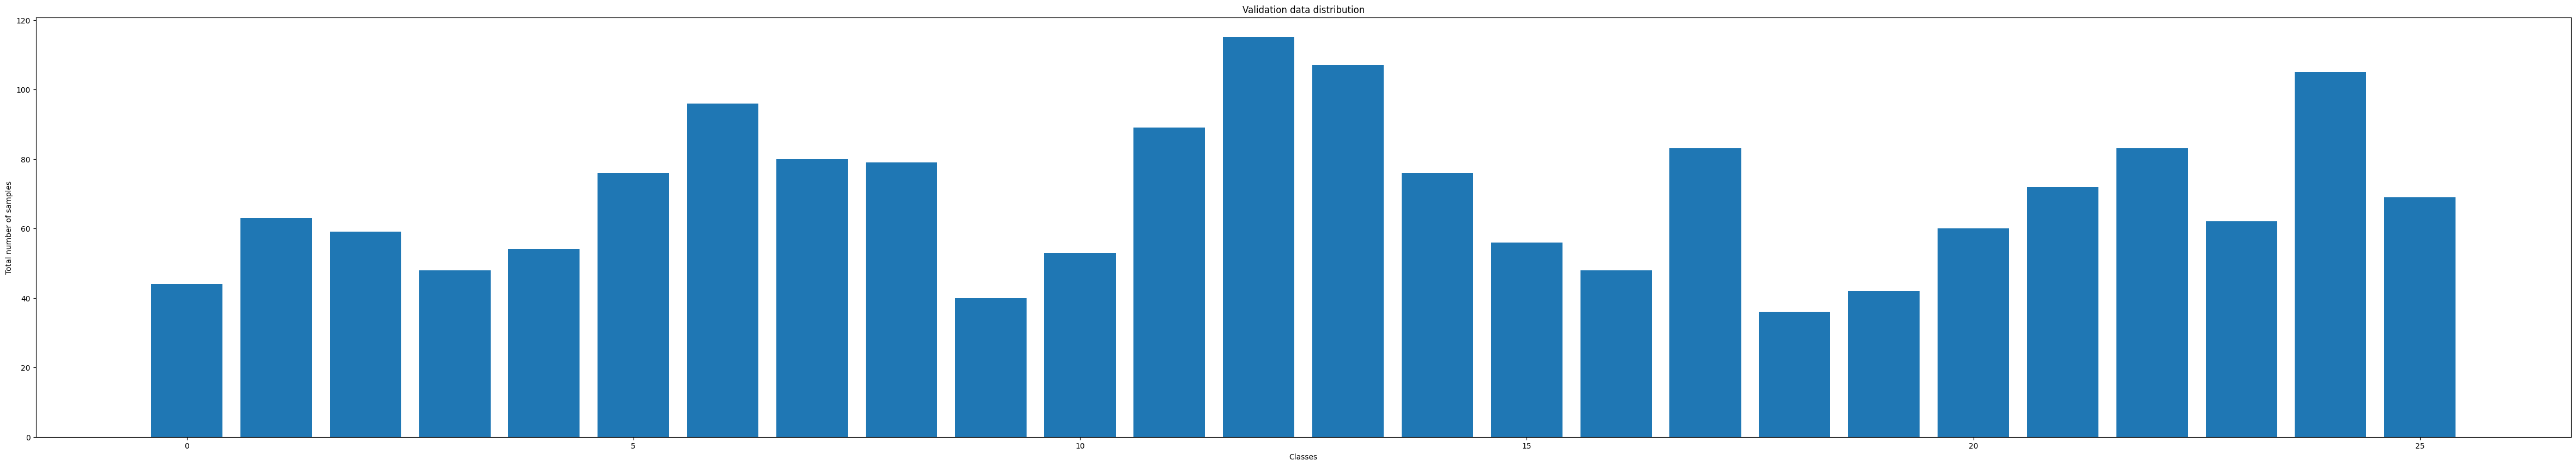

In [ ]:
XX, yy =np.unique(np.argmax(y_valid, axis=-1), return_counts=True)
plt.xlabel('Classes')
plt.ylabel('Total number of samples')
plt.title('Validation data distribution')
plt.bar(XX, yy);

### Testing Data Distribution

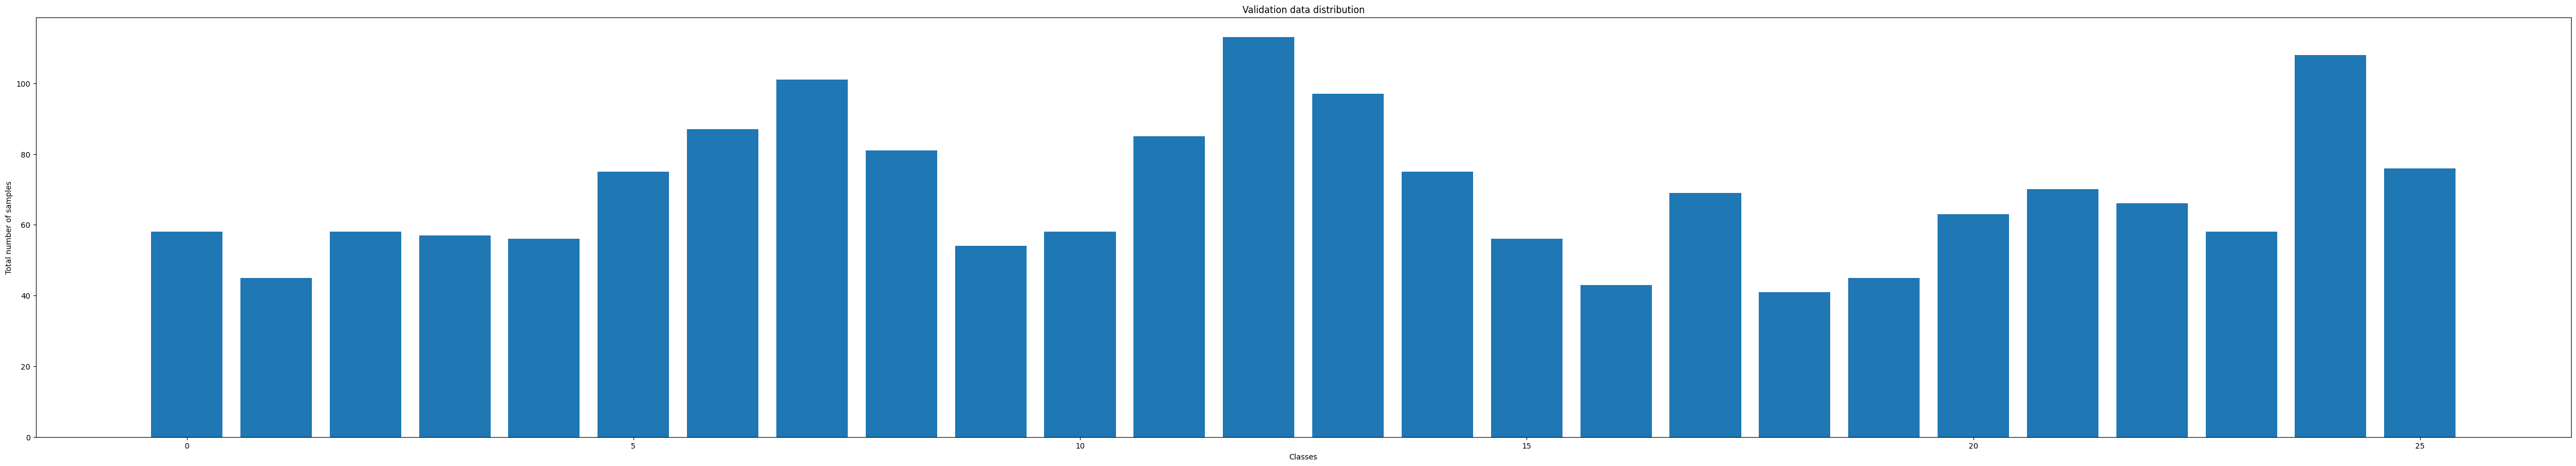

In [ ]:
XX, yy =np.unique(np.argmax(y_test, axis=-1), return_counts=True)
plt.xlabel('Classes')
plt.ylabel('Total number of samples')
plt.title('Validation data distribution')
plt.bar(XX, yy);

## Text vectorization

In [ ]:
np.array([len(np.unique(sentence.split())) for sentence in X]).sum()

172228

In [ ]:
from tensorflow.keras.layers import TextVectorization
vocab_size = 1090410
text_vectorizer = TextVectorization(max_tokens=vocab_size,
                                    standardize="lower_and_strip_punctuation",
                                    output_sequence_length=32)
text_vectorizer.adapt(X_train.to_list())

In [ ]:
text_vocab = text_vectorizer.get_vocabulary()
text_embed = layers.Embedding(input_dim = len(text_vocab),
                              output_dim = 1024,
                              mask_zero = True,
                              name="token_embedding_layer")

In [ ]:
text_embed(text_vectorizer(X_train)).shape

TensorShape([5383, 32, 1024])

## Tf-IdfText Vectorization

In [ ]:
np.array([len(np.unique(sentence.split())) for sentence in X]).sum()

561795

In [ ]:
tfidf_vectorizer = TextVectorization( max_tokens=256000, output_mode='tf-idf', ngrams=(2, 3, 4),
                                      standardize='lower_and_strip_punctuation')
tfidf_vectorizer.adapt(X_train.to_list())

KeyboardInterrupt: ignored

In [ ]:
tfidf_vectorizer.get_vocabulary()[:10], tfidf_vectorizer.get_vocabulary()[-10:]

In [ ]:
tfidf_vectorizer(X_train[:1].to_list())

In [ ]:
text_vocab_2 = tfidf_vectorizer.get_vocabulary()
text_embed_2 = layers.Embedding(input_dim = len(text_vocab_2),
                                output_dim = 2,
                                mask_zero = True,
                                name="token_embedding_layer_2")

## Character Vectorization

In [ ]:
train_chars = [" ".join(list(sent)) for sent in X_train.to_list()]
valid_chars = [" ".join(list(sent)) for sent in X_valid.to_list()]
test_chars = [" ".join(list(sent)) for sent in X_test.to_list()]
char_lens = [len(sentence) for sentence in X_train.to_list()]

In [ ]:
import string
alphabets = string.ascii_lowercase + string.ascii_uppercase + string.digits + '#@'
alphabets

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789#@'

In [ ]:
char_vectorizer = layers.TextVectorization(max_tokens=len(alphabets)+2,
                                           output_sequence_length=int(np.percentile(char_lens,98)),
                                           name="character_vectorizer")
char_vectorizer.adapt(train_chars)

In [ ]:
char_embed = layers.Embedding(input_dim = len(alphabets)+2,
                              output_dim = 25,
                              name = "character_embedding_layer")
char_embed(char_vectorizer(train_chars[17]))

<tf.Tensor: shape=(230, 25), dtype=float32, numpy=
array([[-0.00277632, -0.02023249, -0.01013283, ..., -0.03070824,
        -0.03304694, -0.04756488],
       [-0.02162358,  0.01782498, -0.03410008, ..., -0.0382239 ,
         0.04145912,  0.04834462],
       [ 0.01806435, -0.03075985, -0.0446896 , ...,  0.03014041,
        -0.02906299,  0.00057878],
       ...,
       [ 0.01410251, -0.03546541,  0.03393296, ...,  0.00416879,
        -0.02957306,  0.00611855],
       [ 0.01410251, -0.03546541,  0.03393296, ...,  0.00416879,
        -0.02957306,  0.00611855],
       [ 0.01410251, -0.03546541,  0.03393296, ...,  0.00416879,
        -0.02957306,  0.00611855]], dtype=float32)>

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-13 20:17:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-13 20:17:56 (88.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Accuracy custom

In [ ]:
def acc(y_test, y_preds):
  model_preds = y_preds
  return tf.reduce_mean(tf.cast(tf.argmax(model_preds, axis=-1) == tf.argmax(y_test, axis=-1), dtype=tf.float32))

## Loss curve function

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  acc = history.history['acc']
  val_acc = history.history['val_acc']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot acc
  plt.figure()
  plt.plot(epochs, acc, label='training_acc')
  plt.plot(epochs, val_acc, label='val_acc')
  plt.title('acc')
  plt.xlabel('Epochs')
  plt.legend();

# Initial Modelling...

**Need mapping of the following**

`
tf_hub_token_embed([X[0]]) --> tf_hub_token_embed([y[0]]).shape
`

## Creation of Model

In [ ]:
try:
  del model
except:
  c = 1
tf.random.set_seed(42)
CLASS = len(y.unique())

# # Define your custom activation function
# def custom_activation(x):
#     return 2*tf.math.sigmoid(x)-1  # Example custom activation: square the input

# # Create a custom layer with the custom activation function
# class CustomActivationLayer(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(CustomActivationLayer, self).__init__(**kwargs)

#     def call(self, inputs):
#         return custom_activation(inputs)

# Input layer

text_input = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = tf_hub_token_embed(text_input)

# Stacked LSTM layers
# temb = tf.keras.layers.Reshape((32, 16))(token_embeddings)
# LSTM_layer1 = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(temb)
# # LSTM_layer2 = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(LSTM_layer1)
# # LSTM_layer3 = layers.Bidirectional(layers.LSTM(16))(LSTM_layer2)

# # Fully connnected layer
# # x = layers.Dense(32, activation='relu')(LSTM_layer3)
# # x = layers.Dense(16, activation='relu')(x)
# x = layers.Flatten()(LSTM_layer1)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(CLASS, activation='softmax', name='Ouput_layer')(token_embeddings)

model = tf.keras.Model(inputs = text_input,
                       outputs = outputs,
                       name="The_Location_Extraction_BERT_Model")

In [ ]:
model.summary()

Model: "The_Location_Extraction_BERT_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None,)]                 0         
                                                                 
 tf_hub_trainable_embedding  (None, 512)               256797824 
 _layer (KerasLayer)                                             
                                                                 
 Ouput_layer (Dense)         (None, 59)                30267     
                                                                 
Total params: 256828091 (979.72 MB)
Trainable params: 30267 (118.23 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


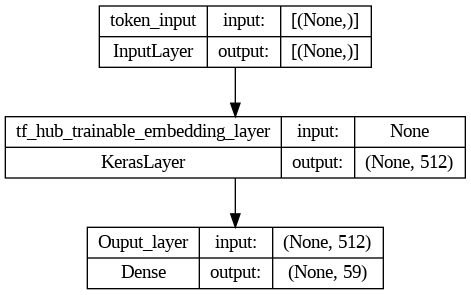

In [ ]:
# Model diagram
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
# Compile the model
# Define the custom loss function
# def custom_loss(y_true, y_pred):
#     # Calculate the cosine similarity
#     cosine_sim = tf.keras.losses.cosine_similarity(y_true, y_pred)

#     # Subtract the cosine similarity from 1
#     loss = 1 - cosine_sim

#     return loss
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[acc])

## Creation of validation and training dataset

In [ ]:
BATCH = 128

In [ ]:
# Get the validing and validation sets ready
# Training Set
training_input_set = tf.data.Dataset.from_tensor_slices((X_train.to_list()))
training_output_set = tf.data.Dataset.from_tensor_slices(y_train)
train_data = tf.data.Dataset.zip((training_input_set, training_output_set))
train_data = train_data.batch(BATCH).prefetch(tf.data.AUTOTUNE)

# ?Validation Set
validation_input_set = tf.data.Dataset.from_tensor_slices((X_valid.to_list()))
validation_output_set = tf.data.Dataset.from_tensor_slices(y_valid)
valid_data = tf.data.Dataset.zip((validation_input_set, validation_output_set))
valid_data = valid_data.batch(BATCH).prefetch(tf.data.AUTOTUNE)

In [ ]:
# ?testing Set
testing_input_set = tf.data.Dataset.from_tensor_slices((X_test.to_list()))
testing_output_set = tf.data.Dataset.from_tensor_slices(y_test)
test_data = tf.data.Dataset.zip((testing_input_set, testing_output_set))
test_data = test_data.batch(BATCH).prefetch(tf.data.AUTOTUNE)

## Training initial Model

In [ ]:
# Fit the model
import warnings
warnings.filterwarnings('ignore')
tf.random.set_seed(7)
history = model.fit(train_data,
                    epochs=80,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    callbacks=[
                                # tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                #                                 patience=5),
                                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                    patience=2,
                                                                    factor=0.1)
                              ]
                      )

Epoch 1/80
61/61 [==============================] - 6s 48ms/step - loss: 4.0111 - acc: 0.1334 - val_loss: 3.9411 - val_acc: 0.2061 - lr: 0.0010
Epoch 2/80
61/61 [==============================] - 2s 35ms/step - loss: 3.8686 - acc: 0.2542 - val_loss: 3.8231 - val_acc: 0.2509 - lr: 0.0010
Epoch 3/80
61/61 [==============================] - 3s 47ms/step - loss: 3.7450 - acc: 0.2812 - val_loss: 3.7188 - val_acc: 0.2677 - lr: 0.0010
Epoch 4/80
61/61 [==============================] - 2s 40ms/step - loss: 3.6341 - acc: 0.2968 - val_loss: 3.6249 - val_acc: 0.2781 - lr: 0.0010
Epoch 5/80
61/61 [==============================] - 3s 44ms/step - loss: 3.5333 - acc: 0.3086 - val_loss: 3.5392 - val_acc: 0.2882 - lr: 0.0010
Epoch 6/80
61/61 [==============================] - 4s 58ms/step - loss: 3.4406 - acc: 0.3186 - val_loss: 3.4604 - val_acc: 0.3013 - lr: 0.0010
Epoch 7/80
61/61 [==============================] - 3s 43ms/step - loss: 3.3551 - acc: 0.3291 - val_loss: 3.3878 - val_acc: 0.3106 - lr:

## Loss-accuracy Curves

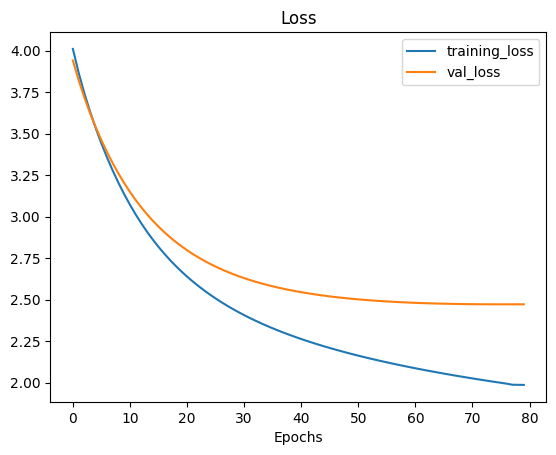

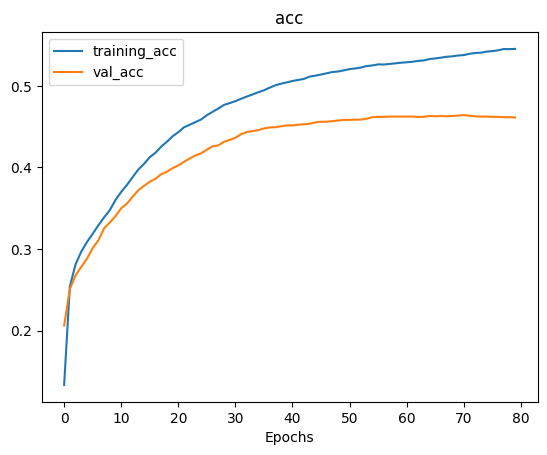

In [ ]:
plot_loss_curves(history)

In [ ]:
model.evaluate(test_data)

21/21 [==============================] - 1s 42ms/step - loss: 2.4593 - acc: 0.4614


[2.4593231678009033, 0.4613771438598633]

In [ ]:
# Predictions
y_preds = model.predict(test_data)

21/21 [==============================] - 1s 19ms/step


In [ ]:
# Confusion matrix creation
y_true = np.concatenate([tf.argmax(y, axis=-1) for x, y in valid_data], axis=0)
y_p = np.argmax(y_preds, axis=-1)
cm = confusion_matrix(y_true=y_true, y_pred=y_p)

In [ ]:
y_true[:10], np.argmax(y_preds, axis=-1)[:10]

(array([53, 48, 20, 15, 18, 52,  8, 15, 57, 29]),
 array([18, 32, 40, 36, 27, 35, 30, 32,  3, 35]))

### Analysis on basis of plot

In [ ]:
first_val = 0 # @param {type:"integer"}
last_val = 20 # @param {type:"integer"}
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(y_p[first_val:last_val], linestyle = '-')
plt.ylabel('Class Number')
plt.xlabel('Samples')
plt.title(f'Prediction of {first_val+1} to {last_val} samples')
plt.subplot(1,2,2)
plt.plot(y_true[first_val:last_val], linestyle = '-')
plt.ylabel('Class Number')
plt.title(f'Truth value of {first_val+1} to {last_val} samples')
plt.xlabel('Samples');

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(y_p, linestyle = '-')
plt.ylabel('Class Number')
plt.xlabel('Samples')
plt.title('Prediction of all the validation samples')
plt.subplot(1,2,2)
plt.plot(y_true, linestyle = '-')
plt.ylabel('Class Number')
plt.xlabel('Samples')
plt.title('Truth value of all the validation samples');

### Analysis on confusion matrix

In [ ]:
sns.heatmap(cm[:20,:20],
            annot=False,
            xticklabels=[],
            yticklabels=[])

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
sns.heatmap(cm,
            annot=False,
            xticklabels=[],
            yticklabels=[])

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

### Testing model performance on training set

In [ ]:
new_model.evaluate(train_data)

In [ ]:
# Predictions
y_preds_train = new_model.predict(train_data)

In [ ]:
# Confusion matrix creation
y_true_train = np.concatenate([tf.argmax(y, axis=-1) for x, y in train_data], axis=0)
y_p_train = np.argmax(y_preds_train, axis=-1)
cm_train = confusion_matrix(y_true=y_true_train, y_pred=y_p_train)

In [ ]:
first_val = 0 # @param {type:"integer"}
last_val = 20 # @param {type:"integer"}
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(y_p_train[first_val:last_val], linestyle = '-')
plt.ylabel('Class Number')
plt.xlabel('Samples')
plt.title(f'Prediction of {first_val+1} to {last_val} samples')
plt.subplot(1,2,2)
plt.plot(y_true_train[first_val:last_val], linestyle = '-')
plt.ylabel('Class Number')
plt.title(f'Truth value of {first_val+1} to {last_val} samples')
plt.xlabel('Samples');

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(y_p_train, linestyle = '-')
plt.ylabel('Class Number')
plt.xlabel('Samples')
plt.title('Prediction of all the validation samples')
plt.subplot(1,2,2)
plt.plot(y_true_train, linestyle = '-')
plt.ylabel('Class Number')
plt.xlabel('Samples')
plt.title('Truth value of all the validation samples');

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(cm_train).plot()

## Wrongly Predicted data (IN CASE OF BINARY SAMPLE)

In [ ]:
database = np.array([{num: encode_place_name(j)} for num,j in enumerate(y)])

In [ ]:
def reverse_bin(binary_num, y_array=database, dtype=np.dtype(np.unicode_, 32)):
  binary_num = list(binary_num)
  for index in range(len(y_array)):
    for key in y_array[index]:
      if y_array[index][key] == binary_num:
        return np.asarray(y[key],dtype=object)
  return np.asarray("Place not listed in Database",dtype=object)

In [ ]:
reverse_bin(encode_place_name(y[2]), database), y[2], reverse_bin(encode_place_name(y[602]), database), y[602]

In [ ]:
y_preds = np.array(tf.cast(y_preds, dtype=tf.uint8))
y_preds

In [ ]:
y_train

In [ ]:
def show_wrong_predictions(y_true, y_preds):
  preedeect = np.apply_along_axis(reverse_bin, -1, y_preds, dtype=np.dtype(np.unicode_,32))
  truuth = np.apply_along_axis(reverse_bin, -1, y_true, dtype=np.dtype(np.unicode_,32))
  return preedeect, truuth
pp, tt = show_wrong_predictions(y_train, y_preds)

In [ ]:
(pp[pp!=tt], tt[pp!=tt])

In [ ]:
len(pp[pp!=tt])

In [ ]:
test_pp, test_tt = show_wrong_predictions(y_test, np.array(tf.cast(valid_preds, dtype=tf.uint8)))
(test_pp[test_pp!=test_tt], test_tt[test_pp!=test_tt])

In [ ]:
len(test_pp[test_pp!=test_tt])

In [ ]:
y_test.shape[0]

In [ ]:
len(y_train)

In [ ]:
print(f"{(1-7971/18963) * 100 :.2f} % accurate")

In [ ]:
print(f"{(1-16268/38499) * 100 :.2f} % accurate")

Tell us how many samples were nearly correctly identified

In [ ]:
y_preds[y_preds<=(-0.5)].shape

In [ ]:
y_preds.shape

# Modelling 0

In [ ]:
tf_one_hot.shape

TensorShape([58007, 5303])

In [ ]:
# Tokenize input statements with BERT model
preprocessor = hub.KerasLayer(
     "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
     trainable=False,
     name="BERT_tf_hub")

In [ ]:
tf.TensorSpec.from_tensor(tf.constant(X_train.to_list(), dtype=tf.string))

TensorSpec(shape=(46405,), dtype=tf.string, name=None)

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)

In [ ]:
encoder_inputs['input_word_ids']

<KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'keras_layer')>

In [ ]:
try:
  del model
except:
  c = 1
tf.random.set_seed(42)
CLASS = len(y.unique())
# # Define your custom activation function
# def custom_activation(x):
#     return 2*tf.math.sigmoid(x)-1  # Example custom activation: square the input

# # Create a custom layer with the custom activation function
# class CustomActivationLayer(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(CustomActivationLayer, self).__init__(**kwargs)

#     def call(self, inputs):
#         return custom_activation(inputs)

# Input layer

token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = preprocessor(token_inputs)['input_word_ids']

# Fully connnected layer
x = tf.keras.layers.BatchNormalization()(tf.cast(token_embeddings, dtype=tf.float32))
x = tf.keras.layers.Dense(1024, activation='tanh')(x)
outputs = layers.Dense(CLASS, activation='sigmoid', name='Ouput_layer')(x)

model = tf.keras.Model(inputs = token_inputs,
                       outputs = outputs,
                       name="The_Location_Extraction_BERT_Model")

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=[acc])

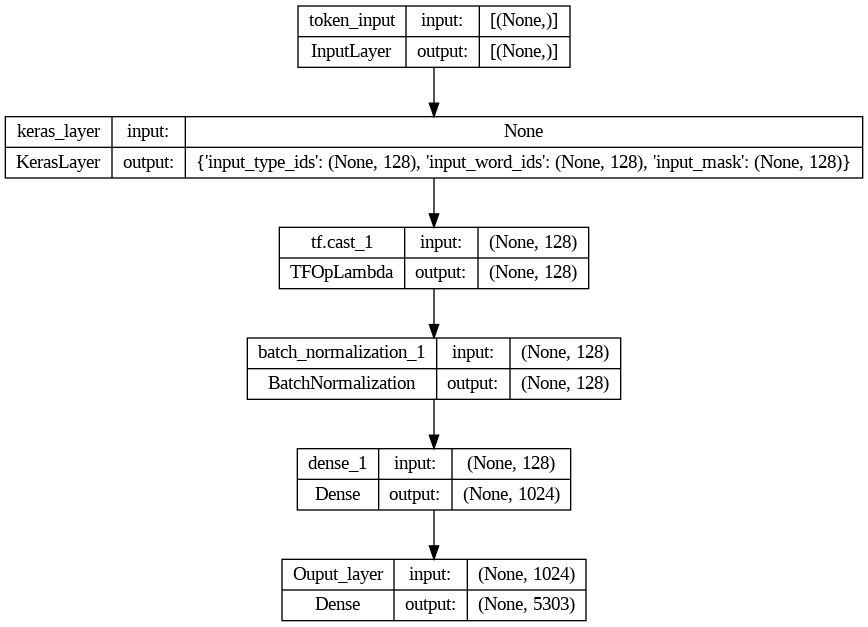

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Fit the model
tf.random.set_seed(42)
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data)
                    )

## Plotting loss curves

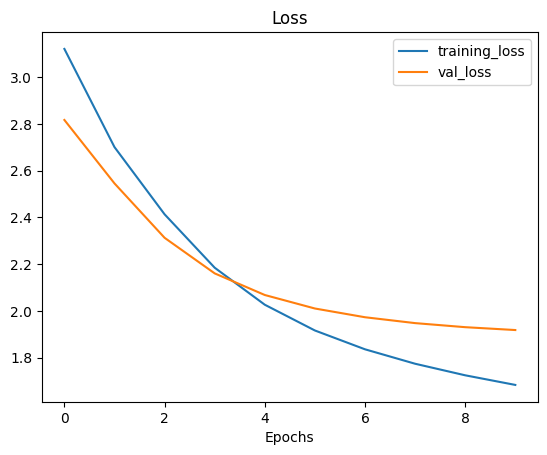

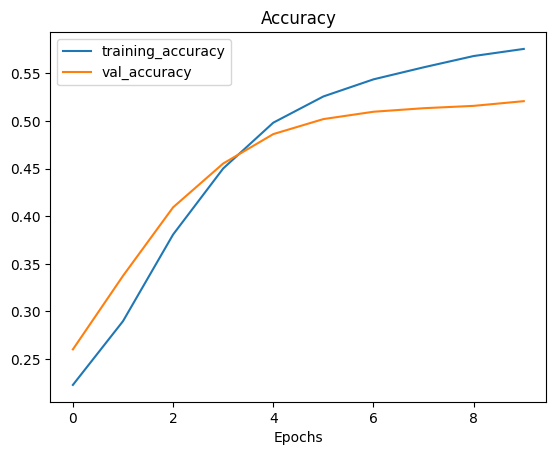

In [ ]:
plot_loss_curves(history)

In [ ]:
new_history = model.fit(
    train_data,
    initial_epoch=history.epoch[-1],
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 10/50
206/206 [==============================] - 4s 18ms/step - loss: 1.6482 - accuracy: 0.5805 - val_loss: 1.9096 - val_accuracy: 0.5228
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: 1.6171 - accuracy: 0.5875 - val_loss: 1.9033 - val_accuracy: 0.5253
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: 1.5892 - accuracy: 0.5933 - val_loss: 1.8989 - val_accuracy: 0.5256
Epoch 13/50
206/206 [==============================] - 5s 23ms/step - loss: 1.5635 - accuracy: 0.5983 - val_loss: 1.8957 - val_accuracy: 0.5269
Epoch 14/50
206/206 [==============================] - 5s 23ms/step - loss: 1.5396 - accuracy: 0.6015 - val_loss: 1.8936 - val_accuracy: 0.5278
Epoch 15/50
206/206 [==============================] - 4s 19ms/step - loss: 1.5171 - accuracy: 0.6051 - val_loss: 1.8924 - val_accuracy: 0.5281
Epoch 16/50
206/206 [==============================] - 6s 31ms/step - loss: 1.4957 - accuracy: 0.6086 - val_loss: 1.8919 - val_accuracy:

## Another loss curve for 50 epochs

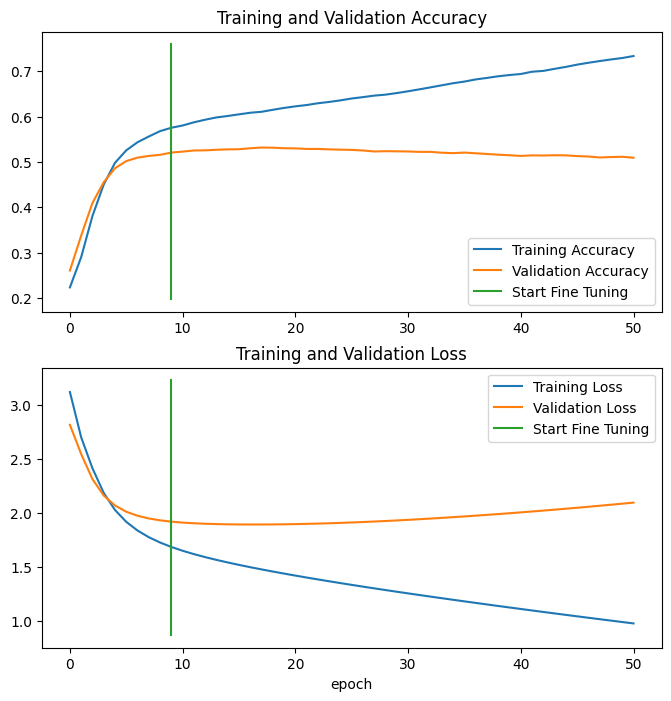

In [ ]:
compare_historys(history,
                 new_history,
                 initial_epochs=10)

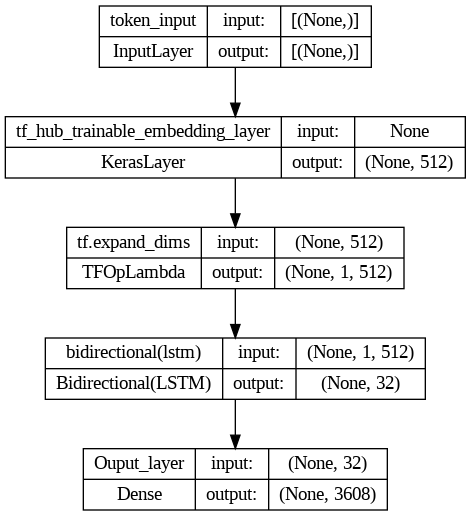

In [ ]:
# Model diagram
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## Model summary

In [ ]:
model.summary()

Model: "The_Location_Extraction_non_BERT_Model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None,)]                 0         
                                                                 
 tf_hub_trainable_embedding  (None, 512)               256797824 
 _layer (KerasLayer)                                             
                                                                 
 tf.expand_dims (TFOpLambda  (None, 1, 512)            0         
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 32)                67712     
 al)                                                             
                                                                 
 Ouput_layer (Dense)         (None, 3608)              119064    
                          

# Modelling 01

In [ ]:
try:
  del model1
except:
  c = 1
tf.random.set_seed(42)
CLASS = 33

text_input = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = tf_hub_token_embed(text_input)

LSTM_layer1 = layers.Bidirectional(layers.LSTM(16, return_sequences=False
                                               )
                                  )(tf.expand_dims(token_embeddings, axis=1))

# Fully connnected layer
x = layers.Dense(100, activation='relu'
                    , kernel_regularizer=tf.keras.regularizers.L1(0.0001)
                    , activity_regularizer=tf.keras.regularizers.L2(0.000001)
                    )(LSTM_layer1)
x = layers.Dense(1000, activation='tanh'
                     , kernel_regularizer=tf.keras.regularizers.L1(0.01)
                     , activity_regularizer=tf.keras.regularizers.L2(0.01))(x)
outputs = layers.Dense(CLASS, activation='softmax', name='Ouput_layer')(LSTM_layer1)

model1 = tf.keras.Model(inputs = text_input,
                       outputs = outputs,
                       name="The_Location_Extraction_non_BERT_Model_01")

In [ ]:
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
new_history = model1.fit(
    train_data,
    # initial_epoch=history.epoch[-1],
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 1/10
206/206 [==============================] - 11s 26ms/step - loss: 3.1247 - accuracy: 0.2194 - val_loss: 2.8267 - val_accuracy: 0.2506
Epoch 2/10
206/206 [==============================] - 4s 18ms/step - loss: 2.7276 - accuracy: 0.2804 - val_loss: 2.5791 - val_accuracy: 0.3296
Epoch 3/10
206/206 [==============================] - 5s 23ms/step - loss: 2.4462 - accuracy: 0.3797 - val_loss: 2.3255 - val_accuracy: 0.4068
Epoch 4/10
206/206 [==============================] - 4s 20ms/step - loss: 2.1954 - accuracy: 0.4549 - val_loss: 2.1552 - val_accuracy: 0.4580
Epoch 5/10
206/206 [==============================] - 4s 18ms/step - loss: 2.0275 - accuracy: 0.4979 - val_loss: 2.0585 - val_accuracy: 0.4858
Epoch 6/10
206/206 [==============================] - 5s 26ms/step - loss: 1.9167 - accuracy: 0.5255 - val_loss: 2.0009 - val_accuracy: 0.5028
Epoch 7/10
206/206 [==============================] - 4s 18ms/step - loss: 1.8377 - accuracy: 0.5419 - val_loss: 1.9644 - val_accuracy: 0.512

In [ ]:
new_history_2 = model1.fit(
    train_data,
    initial_epoch=new_history.epoch[-1],
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 10/100
206/206 [==============================] - 4s 19ms/step - loss: 1.6538 - accuracy: 0.5785 - val_loss: 1.9047 - val_accuracy: 0.5250
Epoch 11/100
206/206 [==============================] - 4s 18ms/step - loss: 1.6230 - accuracy: 0.5851 - val_loss: 1.8992 - val_accuracy: 0.5253
Epoch 12/100
206/206 [==============================] - 5s 26ms/step - loss: 1.5950 - accuracy: 0.5916 - val_loss: 1.8955 - val_accuracy: 0.5253
Epoch 13/100
206/206 [==============================] - 4s 18ms/step - loss: 1.5692 - accuracy: 0.5966 - val_loss: 1.8930 - val_accuracy: 0.5272
Epoch 14/100
206/206 [==============================] - 4s 18ms/step - loss: 1.5452 - accuracy: 0.5998 - val_loss: 1.8916 - val_accuracy: 0.5278
Epoch 15/100
206/206 [==============================] - 7s 33ms/step - loss: 1.5225 - accuracy: 0.6038 - val_loss: 1.8909 - val_accuracy: 0.5299
Epoch 16/100
206/206 [==============================] - 4s 19ms/step - loss: 1.5009 - accuracy: 0.6071 - val_loss: 1.8910 - val_ac

In [ ]:
model1.evaluate(valid_data)

102/102 [==============================] - 2s 22ms/step - loss: 2.8161 - accuracy: 0.4731


[2.816101312637329, 0.4731481373310089]

## Plotting loss curve

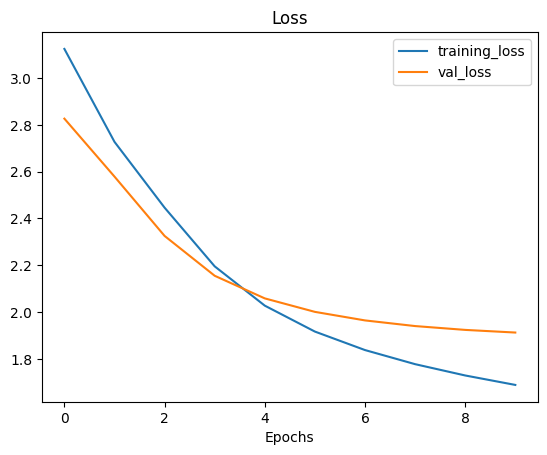

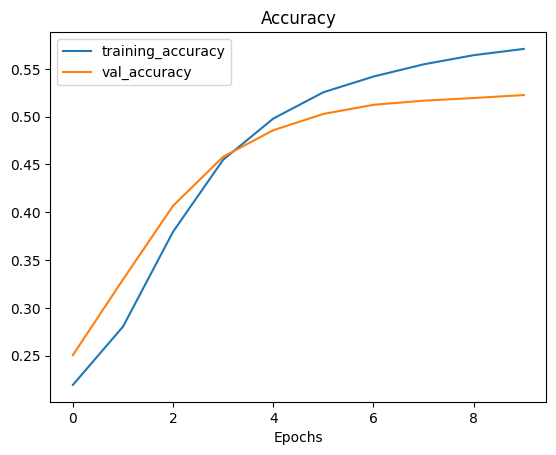

In [ ]:
plot_loss_curves(new_history)

## Comparing performances

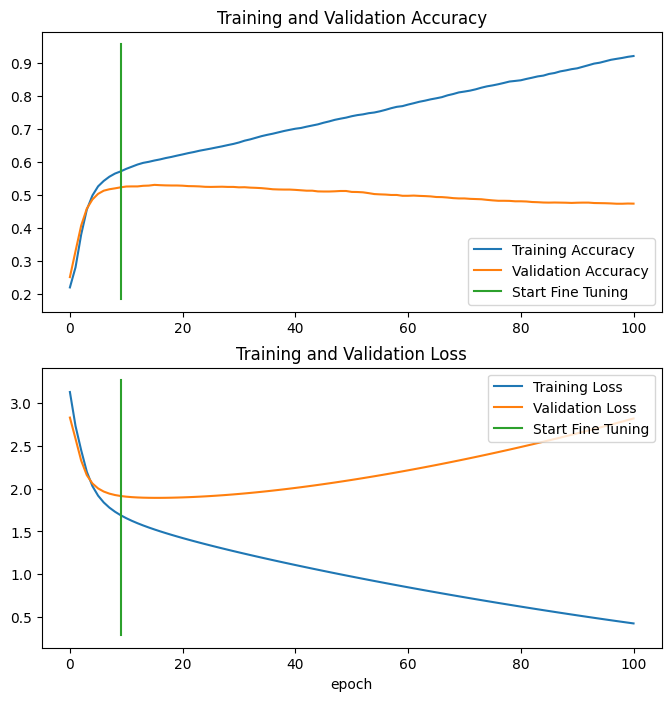

In [ ]:
compare_historys(new_history,
                 new_history_2,
                 initial_epochs=10)

## Model Summary

In [ ]:
model1.summary()

Model: "The_Location_Extraction_non_BERT_Model_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None,)]                 0         
                                                                 
 tf_hub_trainable_embedding  (None, 512)               256797824 
 _layer (KerasLayer)                                             
                                                                 
 tf.expand_dims_2 (TFOpLamb  (None, 1, 512)            0         
 da)                                                             
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                67712     
 onal)                                                           
                                                                 
 Ouput_layer (Dense)         (None, 33)                1089      
                         

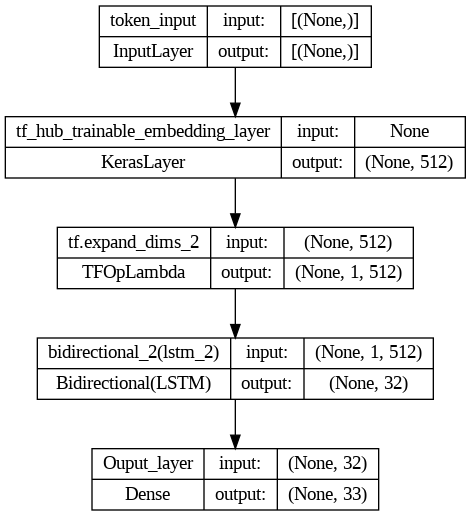

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model1, show_shapes=True)

# Modelling 02

In [ ]:
try:
  del model01
except:
  c = 1
tf.random.set_seed(42)
CLASS = 33

text_input = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = tf_hub_token_embed(text_input)

LSTM_layer1 = layers.Bidirectional(layers.LSTM(16, return_sequences=False
                                               )
                                  )(tf.expand_dims(token_embeddings, axis=1))

# Fully connnected layer
x = layers.Dense(100, activation='relu'
                    , kernel_regularizer=tf.keras.regularizers.L1(0.0001)
                    , activity_regularizer=tf.keras.regularizers.L2(0.000001)
                )(LSTM_layer1)
x = layers.Dense(1000, activation='relu'
                    #  , kernel_regularizer=tf.keras.regularizers.L1(0.01)
                    #  , activity_regularizer=tf.keras.regularizers.L2(0.01)
                )(x)
x = layers.Dense(2000, activation='relu'
                    #  , kernel_regularizer=tf.keras.regularizers.L1(0.01)
                    #  , activity_regularizer=tf.keras.regularizers.L2(0.01)
                )(x)
x = layers.Dense(3000, activation='tanh'
                     , kernel_regularizer=tf.keras.regularizers.L1(0.01)
                     , activity_regularizer=tf.keras.regularizers.L2(0.01)
                )(x)
outputs = layers.Dense(CLASS, activation='softmax', name='Ouput_layer')(LSTM_layer1)

model01 = tf.keras.Model(inputs = text_input,
                         outputs = outputs,
                         name="The_Location_Extraction_non_BERT_Model_01")

In [ ]:
model01.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
new_history_01_1 = model01.fit(
    train_data,
    # initial_epoch=history.epoch[-1],
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 1/10
206/206 [==============================] - 10s 25ms/step - loss: 3.1313 - accuracy: 0.2322 - val_loss: 2.8105 - val_accuracy: 0.2728
Epoch 2/10
206/206 [==============================] - 8s 39ms/step - loss: 2.7006 - accuracy: 0.2907 - val_loss: 2.5479 - val_accuracy: 0.3327
Epoch 3/10
206/206 [==============================] - 8s 37ms/step - loss: 2.4186 - accuracy: 0.3812 - val_loss: 2.3061 - val_accuracy: 0.4170
Epoch 4/10
206/206 [==============================] - 5s 25ms/step - loss: 2.1790 - accuracy: 0.4593 - val_loss: 2.1478 - val_accuracy: 0.4673
Epoch 5/10
206/206 [==============================] - 6s 28ms/step - loss: 2.0177 - accuracy: 0.5046 - val_loss: 2.0584 - val_accuracy: 0.4929
Epoch 6/10
206/206 [==============================] - 4s 20ms/step - loss: 1.9110 - accuracy: 0.5276 - val_loss: 2.0062 - val_accuracy: 0.5040
Epoch 7/10
206/206 [==============================] - 6s 27ms/step - loss: 1.8356 - accuracy: 0.5425 - val_loss: 1.9736 - val_accuracy: 0.511

In [ ]:
new_history_01_2 = model01.fit(
    train_data,
    initial_epoch=new_history_01_1.epoch[-1],
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 10/100
206/206 [==============================] - 6s 29ms/step - loss: 1.6597 - accuracy: 0.5749 - val_loss: 1.9190 - val_accuracy: 0.5179
Epoch 11/100
206/206 [==============================] - 6s 29ms/step - loss: 1.6296 - accuracy: 0.5807 - val_loss: 1.9134 - val_accuracy: 0.5173
Epoch 12/100
206/206 [==============================] - 4s 20ms/step - loss: 1.6022 - accuracy: 0.5899 - val_loss: 1.9094 - val_accuracy: 0.5176
Epoch 13/100
206/206 [==============================] - 5s 27ms/step - loss: 1.5768 - accuracy: 0.5942 - val_loss: 1.9065 - val_accuracy: 0.5191
Epoch 14/100
206/206 [==============================] - 5s 23ms/step - loss: 1.5529 - accuracy: 0.5991 - val_loss: 1.9044 - val_accuracy: 0.5194
Epoch 15/100
206/206 [==============================] - 4s 20ms/step - loss: 1.5304 - accuracy: 0.6047 - val_loss: 1.9031 - val_accuracy: 0.5216
Epoch 16/100
206/206 [==============================] - 6s 27ms/step - loss: 1.5088 - accuracy: 0.6088 - val_loss: 1.9025 - val_ac

## Plotting Loss curve

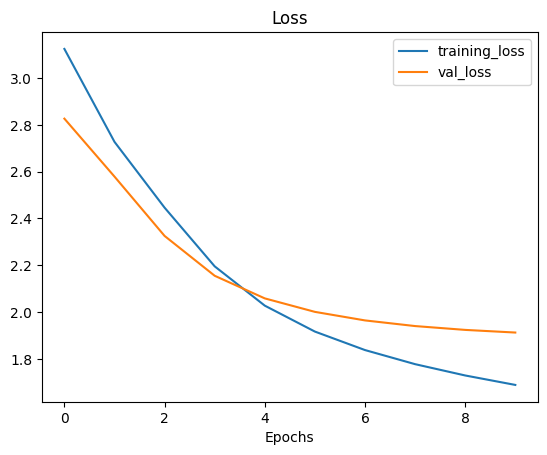

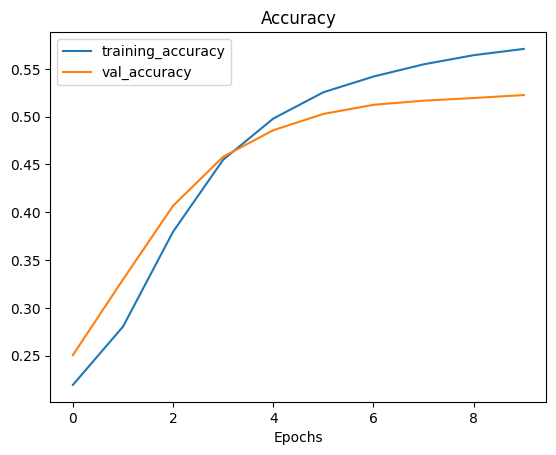

In [ ]:
plot_loss_curves(new_history)

## Comparing Performances

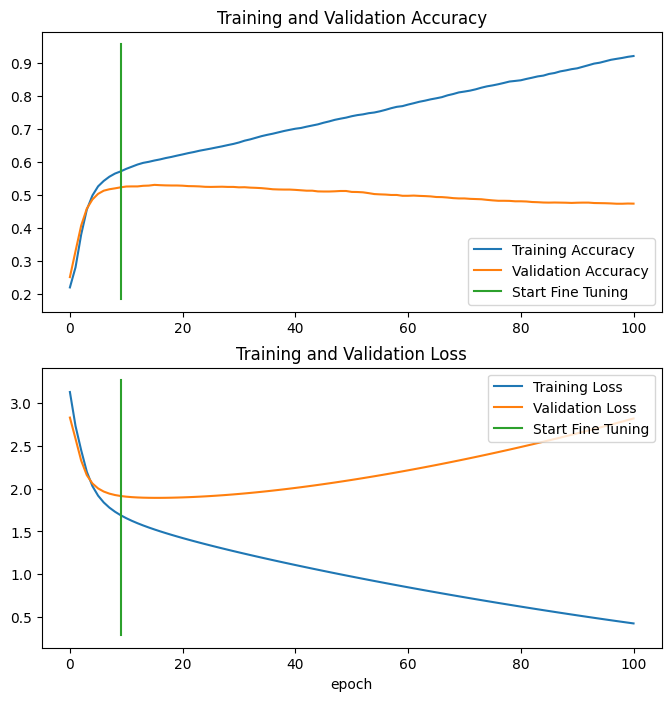

In [ ]:
compare_historys(new_history,
                 new_history_2,
                 initial_epochs=10)

## Model Summary

In [ ]:
model01.summary()

Model: "The_Location_Extraction_non_BERT_Model_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None,)]                 0         
                                                                 
 tf_hub_trainable_embedding  (None, 512)               256797824 
 _layer (KerasLayer)                                             
                                                                 
 tf.expand_dims_4 (TFOpLamb  (None, 1, 512)            0         
 da)                                                             
                                                                 
 bidirectional_4 (Bidirecti  (None, 32)                67712     
 onal)                                                           
                                                                 
 Ouput_layer (Dense)         (None, 33)                1089      
                         

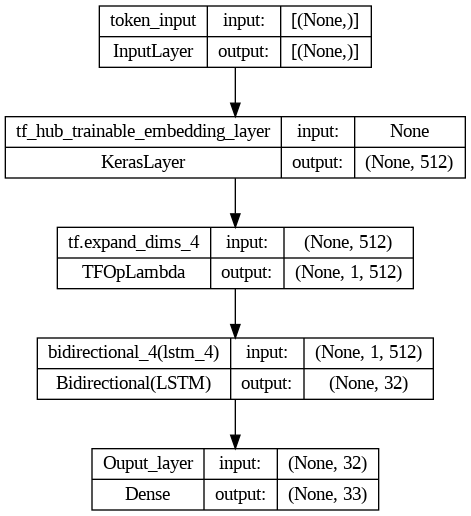

In [ ]:
plot_model(model01, show_shapes=True)

# Modelling 1

In [ ]:
len(y.unique())

33

In [ ]:
CLASSES = len(y.unique())
# 1. tokens
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_token_embed(token_inputs)

# 2. character
char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectorize = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectorize)
char_bi_lstm = layers.Bidirectional(layers.LSTM(128), name="biLSTM")(char_embeddings)


# 5. Concatenate-1
char_token_concat = layers.Concatenate(name="token_char_concatenation")([token_embeddings,
                                                                         char_bi_lstm])
drop_char_token = layers.Dropout(0.5)(char_token_concat)

# 6. Bi-LSTM to concatenated token char
char_token_bi_lstm = layers.Bidirectional(layers.LSTM(32))(tf.expand_dims(drop_char_token, axis=1))


# 9. CNN
cnn_inputs = layers.Input(shape=(1,), dtype=tf.string, name="custom_token_embedding")
text_vectors_cnn = text_vectorizer(cnn_inputs)
token_embeddings_cnn = text_embed(text_vectors_cnn)
x_cnn = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings_cnn)
x_cnn = layers.GlobalAveragePooling1D()(x_cnn)
cnn_outputs = layers.Dense(64, activation="relu")(x_cnn)

# 10. Concatenate-4
cnn_char_token_line_numbers_total_lines_concat = layers.Concatenate(name="cnn_token_char_concatenation")([char_token_bi_lstm,
                                                                                                          cnn_outputs])
final_drop = layers.Dropout(0.2)(cnn_char_token_line_numbers_total_lines_concat)

# 11. Output Layer
x = layers.Dense(64, activation="relu", name="Output_layer")(final_drop)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
output_layer = layers.Dense(CLASSES, activation='softmax', name='Ouput_layer')(x)

# 12. Modelate
model_big = tf.keras.Model(inputs = [token_inputs,
                                 char_inputs,
                                 cnn_inputs],
                       outputs = output_layer,
                       name="The_Ultimate_Model")

In [ ]:
model_big.summary()

Model: "The_Ultimate_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 character_vectorizer (Text  (None, 228)                  0         ['input_4[0][0]']             
 Vectorization)                                                                                   
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 character_embedding_layer   (None, 228, 25)              1600      ['character_v

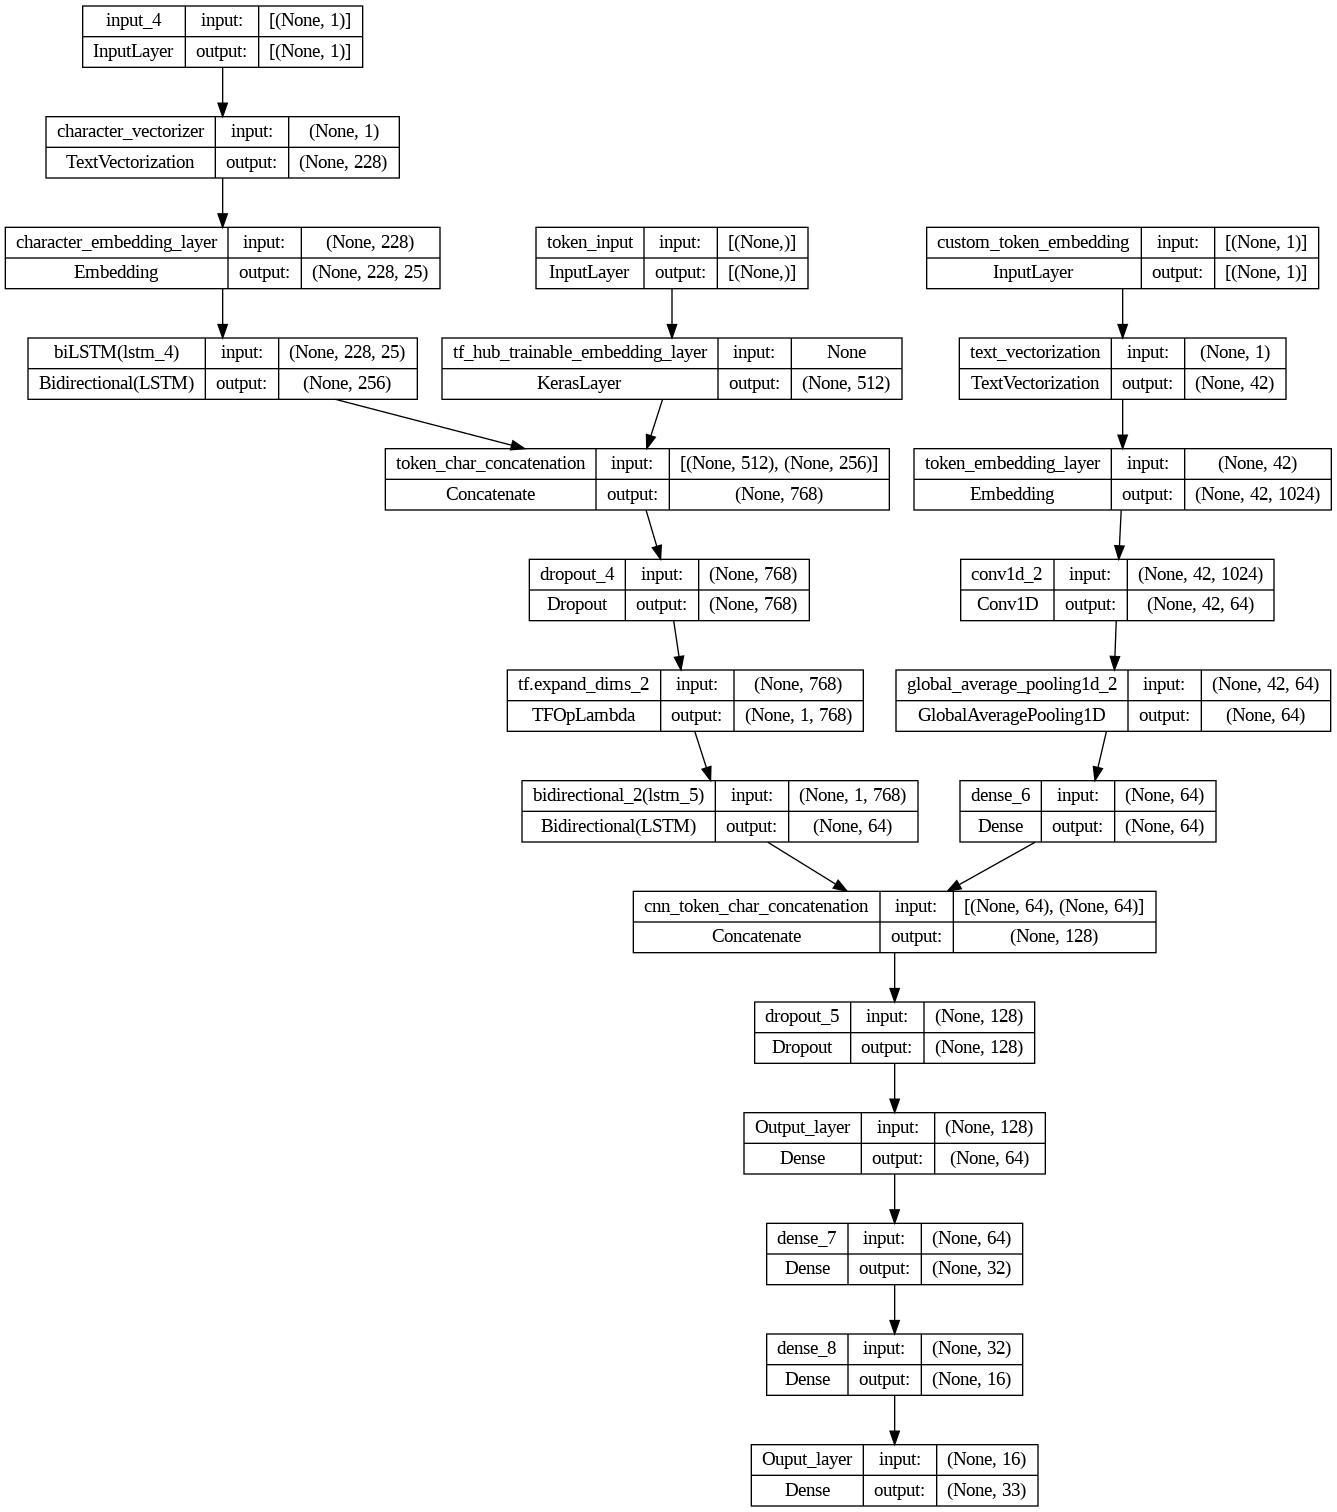

In [ ]:
# Model diagram
from tensorflow.keras.utils import plot_model
plot_model(model_big, show_shapes=True)

In [ ]:
# binary_string = tf.round(tf.constant([[1,1,1,0,0,0], [1,1,0,0,0,1]]))
# results = tf.reduce_sum(
#     tf.cast(tf.reverse(tensor=binary_string, axis=[-1]), dtype=tf.int64)
#     * 2 ** tf.range(tf.cast(6, dtype=tf.int64)), axis=-1)
# results

In [ ]:
# Compile the model
model_big.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])


## Creating Dataset form tensor slices

In [ ]:
# Get the validing and validation sets ready
# Training Set
training_input_set = tf.data.Dataset.from_tensor_slices((X_train.to_list(), train_chars, X_train.to_list()))
training_output_set = tf.data.Dataset.from_tensor_slices(y_train)
train_data = tf.data.Dataset.zip((training_input_set, training_output_set))
train_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)

# ?Validation Set
validation_input_set = tf.data.Dataset.from_tensor_slices((X_test.to_list(), valid_chars, X_test.to_list()))
validation_output_set = tf.data.Dataset.from_tensor_slices(y_test)
valid_data = tf.data.Dataset.zip((validation_input_set, validation_output_set))
valid_data = valid_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-11-05 15:56:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-05 15:56:25 (92.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Fit the model
tf.random.set_seed(42)
history_big = model_big.fit(train_data,
                            epochs=10,
                            steps_per_epoch=len(train_data),
                            validation_data=valid_data,
                            validation_steps=len(valid_data))

Epoch 1/10
206/206 [==============================] - 50s 128ms/step - loss: 3.0329 - accuracy: 0.2019 - val_loss: 2.7737 - val_accuracy: 0.2142
Epoch 2/10
206/206 [==============================] - 12s 56ms/step - loss: 2.4289 - accuracy: 0.2962 - val_loss: 2.7461 - val_accuracy: 0.3127
Epoch 3/10
206/206 [==============================] - 10s 46ms/step - loss: 1.9601 - accuracy: 0.4113 - val_loss: 2.7481 - val_accuracy: 0.3102
Epoch 4/10
206/206 [==============================] - 11s 55ms/step - loss: 1.5298 - accuracy: 0.5013 - val_loss: 3.1829 - val_accuracy: 0.3611
Epoch 5/10
206/206 [==============================] - 11s 54ms/step - loss: 1.1338 - accuracy: 0.6167 - val_loss: 3.7362 - val_accuracy: 0.4127
Epoch 6/10
206/206 [==============================] - 10s 50ms/step - loss: 0.8813 - accuracy: 0.6964 - val_loss: 4.4303 - val_accuracy: 0.4188
Epoch 7/10
206/206 [==============================] - 11s 54ms/step - loss: 0.6811 - accuracy: 0.7522 - val_loss: 4.7061 - val_accuracy

In [ ]:
new_history_big = model_big.fit(
    train_data,
    initial_epoch=history_big.epoch[-1],
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 10/100
206/206 [==============================] - 11s 56ms/step - loss: 0.3014 - accuracy: 0.8952 - val_loss: 5.2958 - val_accuracy: 0.4398
Epoch 11/100
206/206 [==============================] - 11s 54ms/step - loss: 0.2631 - accuracy: 0.9106 - val_loss: 6.0008 - val_accuracy: 0.4522
Epoch 12/100
206/206 [==============================] - 12s 59ms/step - loss: 0.2244 - accuracy: 0.9278 - val_loss: 6.2093 - val_accuracy: 0.4676
Epoch 13/100
206/206 [==============================] - 12s 57ms/step - loss: 0.1652 - accuracy: 0.9474 - val_loss: 6.7166 - val_accuracy: 0.4645
Epoch 14/100
206/206 [==============================] - 11s 55ms/step - loss: 0.1267 - accuracy: 0.9614 - val_loss: 7.2119 - val_accuracy: 0.4728
Epoch 15/100
206/206 [==============================] - 13s 64ms/step - loss: 0.1049 - accuracy: 0.9700 - val_loss: 7.8053 - val_accuracy: 0.4503
Epoch 16/100
206/206 [==============================] - 11s 56ms/step - loss: 0.0784 - accuracy: 0.9798 - val_loss: 8.1215 -

## Plot Loss Curves

In [ ]:
from helper_functions import *

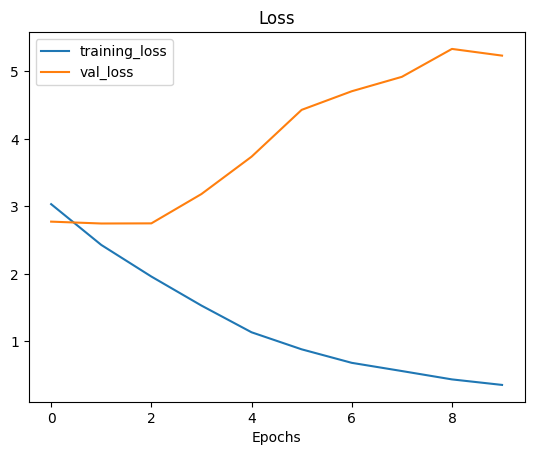

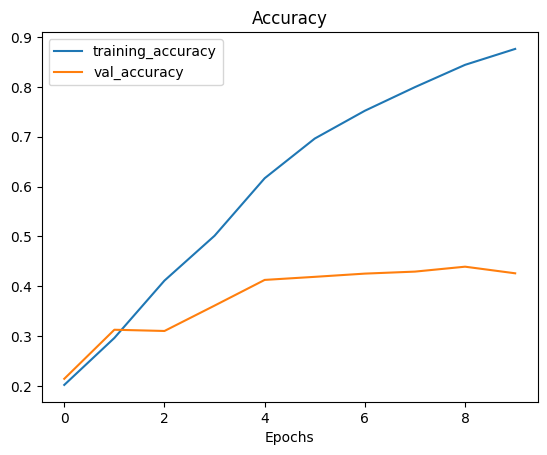

In [ ]:
plot_loss_curves(history_big)

## Comparing histories

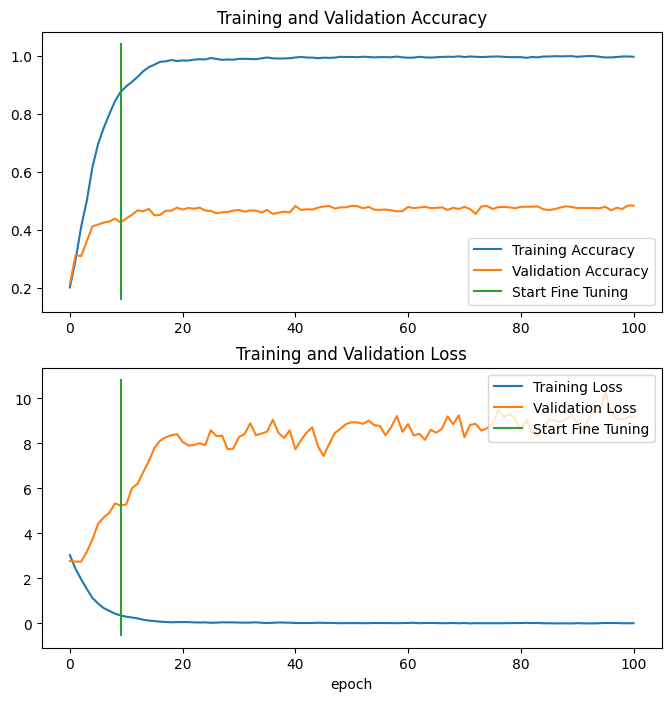

In [ ]:
compare_historys(history_big,
                 new_history_big,
                 initial_epochs=10)

In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir /content/drive/MyDrive/GeoData_Extraction/Sigmoidal_Loss \
#   --name "NLP geo extraction experiment sigmoidal" \
#   --description "..." \
#   --one_shot # exits the uploader when upload has finished

2023-10-09 15:52:54.473260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 15:52:55.348945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-09 15:52:56.809064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 15:52:56.844113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [ ]:
# !tensorboard dev upload --logdir /content/drive/MyDrive/GeoData_Extraction/second_model_Categorical_Hinge_loss \
#   --name "NLP geo extraction experiment second_model categorical hinge loss" \
#   --description "A series of different geodata extraction experiments with various models" \
#   --one_shot # exits the uploader when upload has finished

2023-10-09 15:53:11.435748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 15:53:12.345265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-09 15:53:13.807582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 15:53:13.836615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [ ]:
# !tensorboard dev upload --logdir /content/drive/MyDrive/GeoData_Extraction/tf_hub_sentence_encoder_1000_epochs \
#   --name "tf-hub_sen_encoder" \
#   --description "A series of different geodata extraction experiments with various models" \
#   --one_shot # exits the uploader when upload has finished--one-shot

2023-10-09 15:47:21.528302: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 15:47:22.411522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard
       [-h]
       [--helpfull]
       {serve,dev}
       ...
tensorboard: error: unrecognized arguments: /content/drive/MyDrive/GeoData_Extraction/tf_hub_sentence_encoder_1000_epochs
2023-10-09 15:47:25.778005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 15:47:27.112268: W tensorflow/compiler

# Modelling 2

In [ ]:
CLASSES = len(y.unique())
# 1. tokens
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_token_embed(token_inputs)

# 2. character
char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectorize = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectorize)
char_bi_lstm = layers.Bidirectional(layers.LSTM(128), name="biLSTM")(char_embeddings)


# 5. Concatenate-1
char_token_concat = layers.Concatenate(name="token_char_concatenation")([token_embeddings,
                                                                         char_bi_lstm])
drop_char_token = layers.Dropout(0.5)(char_token_concat)

# 6. Bi-LSTM to concatenated token char
char_token_bi_lstm = layers.Bidirectional(layers.LSTM(32))(tf.expand_dims(drop_char_token, axis=1))


# 9. CNN
cnn_inputs = layers.Input(shape=(1,), dtype=tf.string, name="custom_token_embedding")
text_vectors_cnn = text_vectorizer(cnn_inputs)
token_embeddings_cnn = text_embed(text_vectors_cnn)
x_cnn = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings_cnn)
x_cnn = layers.GlobalAveragePooling1D()(x_cnn)
cnn_outputs = layers.Dense(64, activation="relu")(x_cnn)

# 10. Concatenate-4
cnn_char_token_line_numbers_total_lines_concat = layers.Concatenate(name="cnn_token_char_concatenation")([char_token_bi_lstm,
                                                                                                          cnn_outputs])
final_drop = layers.Dropout(0.2)(cnn_char_token_line_numbers_total_lines_concat)

# 11. Output Layer
x = layers.Dense(64, activation="relu", name="Output_layer")(final_drop)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
output_layer = layers.Dense(CLASSES, activation='softmax', name='Ouput_layer')(x)

# 12. Modelate
model_big = tf.keras.Model(inputs = [token_inputs,
                                 char_inputs,
                                 cnn_inputs],
                            outputs = output_layer,
                            name="The_Ultimate_Model")

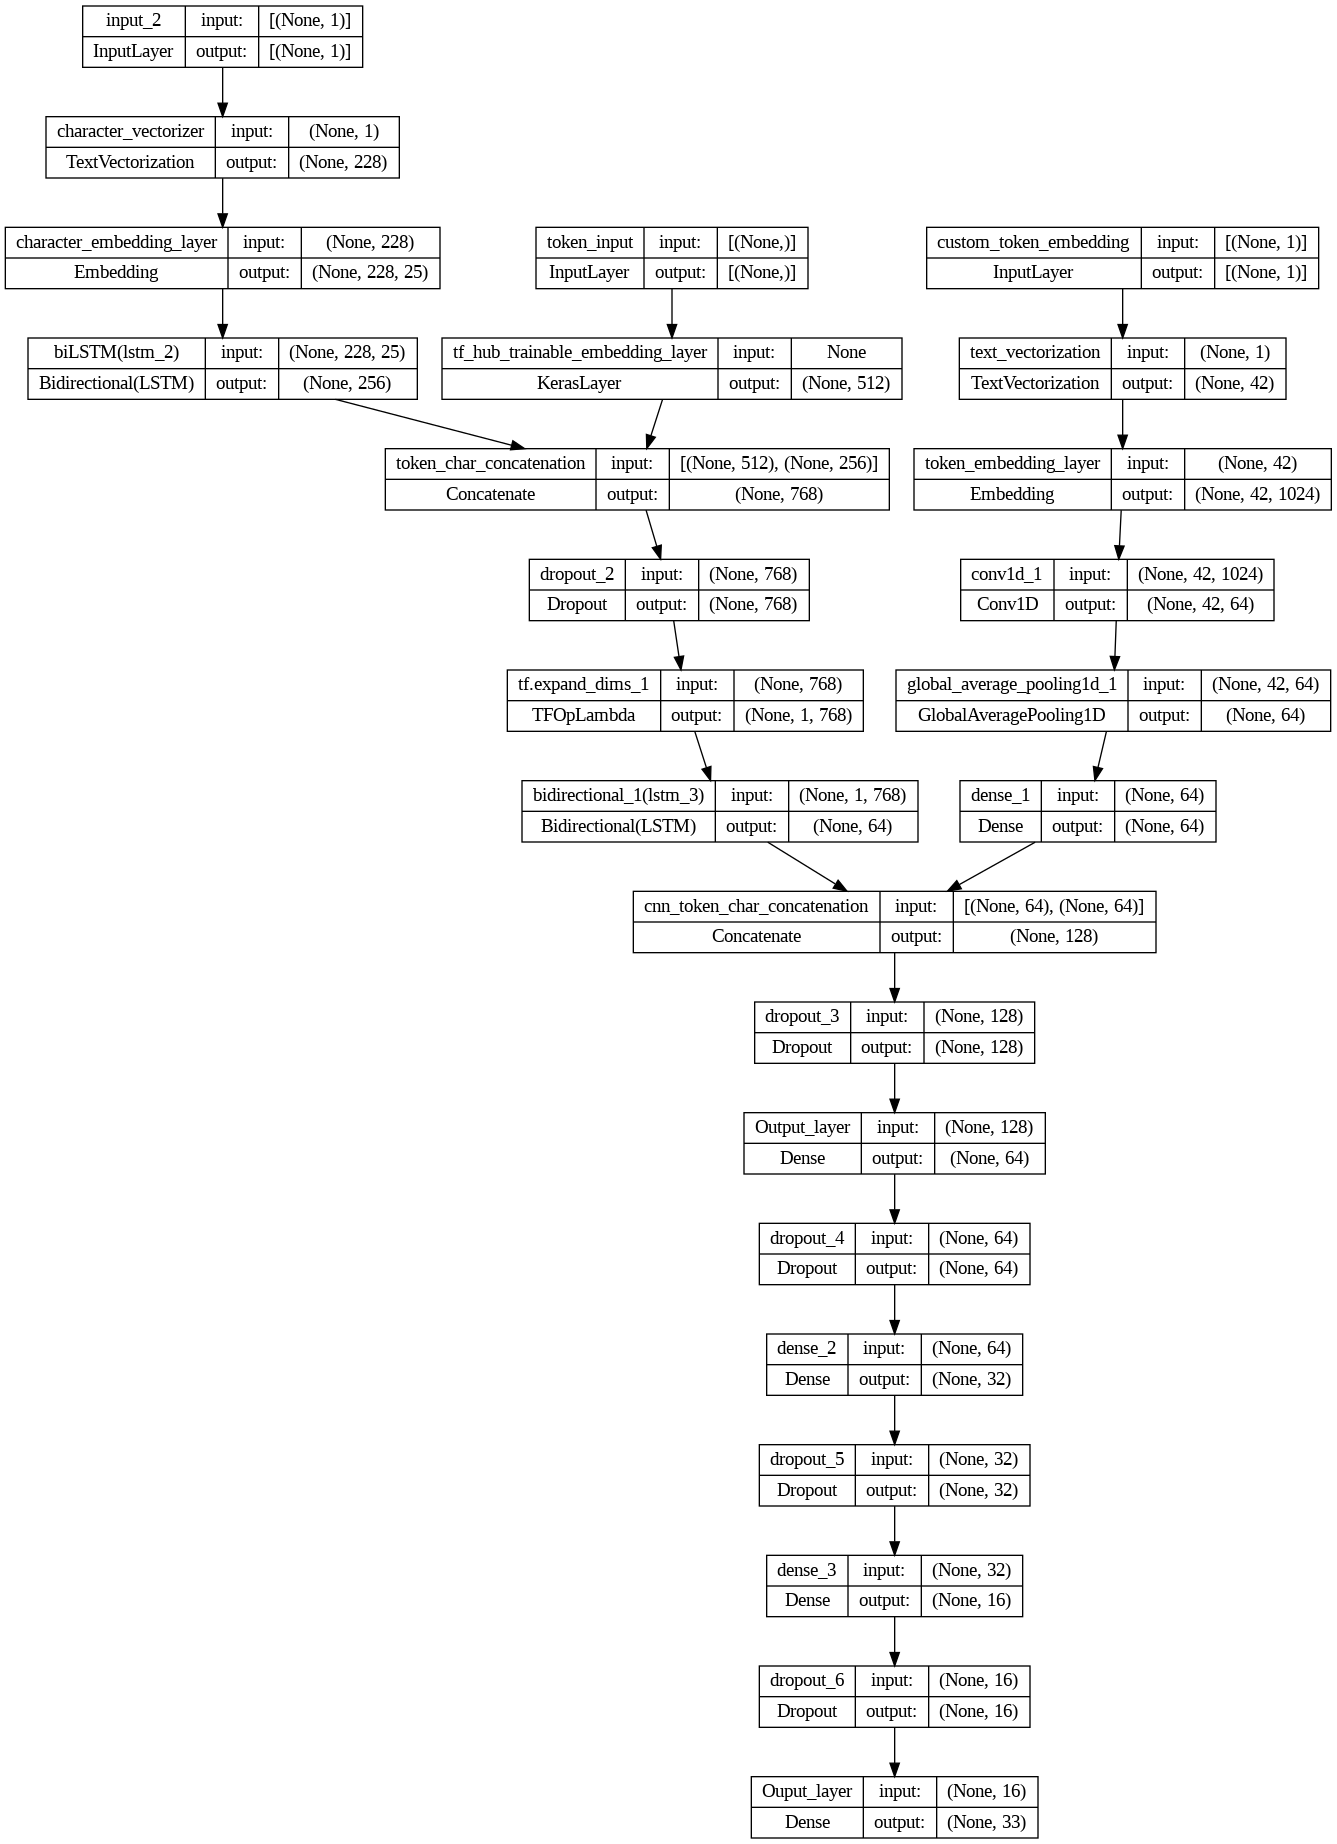

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_big, show_shapes=True)

In [ ]:
# Compile the model
model_big.compile(loss='CategoricalCrossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["accuracy"])

In [ ]:
train_data

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 33), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
history_big2 = model_big.fit(train_data,
                      epochs=10,
                      steps_per_epoch=len(train_data),
                      validation_data=valid_data,
                      validation_steps=len(valid_data)
                      # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss',
                      #                                           patience=6,
                      #                                           min_delta=0.0001,
                      #                                           mode='min')
                      #           ]
                      )

In [ ]:
new_history_big2 = model_big.fit(
    train_data,
    initial_epoch=history_big.epoch[-1],
    epochs=300,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 10/300
206/206 [==============================] - 11s 55ms/step - loss: 0.0643 - accuracy: 0.9989 - val_loss: 2.8724 - val_accuracy: 0.5383
Epoch 11/300
206/206 [==============================] - 10s 51ms/step - loss: 0.0634 - accuracy: 0.9985 - val_loss: 2.9315 - val_accuracy: 0.5275
Epoch 12/300
206/206 [==============================] - 11s 51ms/step - loss: 0.0602 - accuracy: 0.9985 - val_loss: 2.8179 - val_accuracy: 0.5429
Epoch 13/300
206/206 [==============================] - 11s 54ms/step - loss: 0.0592 - accuracy: 0.9988 - val_loss: 2.9044 - val_accuracy: 0.5417
Epoch 14/300
206/206 [==============================] - 11s 55ms/step - loss: 0.0518 - accuracy: 0.9998 - val_loss: 2.9457 - val_accuracy: 0.5512
Epoch 15/300
206/206 [==============================] - 11s 55ms/step - loss: 0.0505 - accuracy: 0.9992 - val_loss: 2.9245 - val_accuracy: 0.5343
Epoch 16/300
206/206 [==============================] - 14s 66ms/step - loss: 0.0521 - accuracy: 0.9980 - val_loss: 2.8529 -

## Plot loss curve

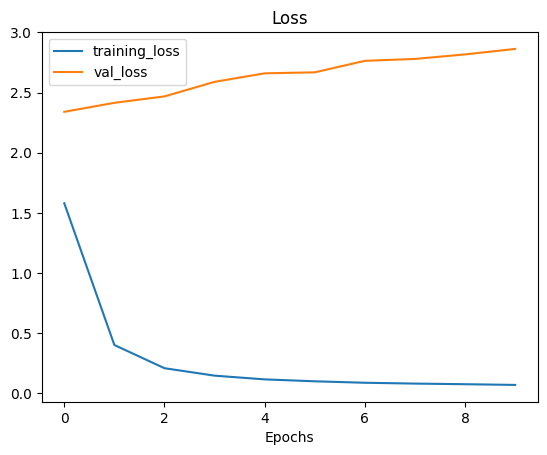

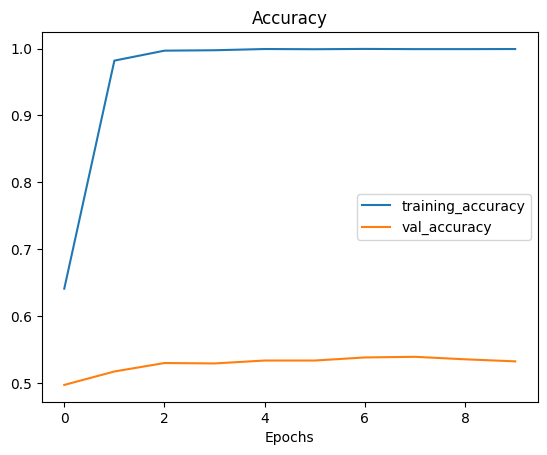

In [ ]:
plot_loss_curves(history_big2)

## Comparing histories

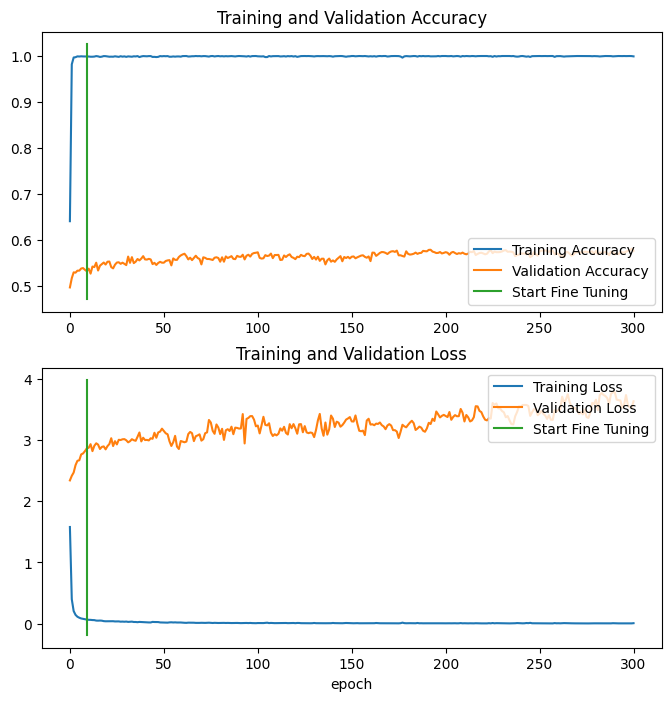

In [ ]:
compare_historys(history_big2,
                 new_history_big2,
                 initial_epochs=10)

# Modelling 3

In [ ]:
try:
  model_big
except:
  mb=1
CLASSES = len(y.unique())
# 1. tokens
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_token_embed(token_inputs)

# 2. character
char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectorize = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectorize)
char_bi_lstm = layers.Bidirectional(layers.LSTM(128), name="biLSTM")(char_embeddings)


# 5. Concatenate-1
char_token_concat = layers.Concatenate(name="token_char_concatenation")([token_embeddings,
                                                                         char_bi_lstm])
drop_char_token = layers.Dropout(0.5)(char_token_concat)

# 6. Bi-LSTM to concatenated token char
char_token_bi_lstm = layers.Bidirectional(layers.LSTM(32))(tf.expand_dims(drop_char_token, axis=1))


# 9. CNN
cnn_inputs = layers.Input(shape=(1,), dtype=tf.string, name="custom_token_embedding")
text_vectors_cnn = text_vectorizer(cnn_inputs)
token_embeddings_cnn = text_embed(text_vectors_cnn)
x_cnn = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings_cnn)
x_cnn = layers.GlobalAveragePooling1D()(x_cnn)
cnn_outputs = layers.Dense(64, activation="relu")(x_cnn)

# 10. Concatenate-4
cnn_char_token_line_numbers_total_lines_concat = layers.Concatenate(name="cnn_token_char_concatenation")([char_token_bi_lstm,
                                                                                                          cnn_outputs])
final_drop = layers.Dropout(0.2)(cnn_char_token_line_numbers_total_lines_concat)

# 11. Output Layer
x = layers.Dense(64, activation="relu", name="Output_layer")(final_drop)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(CLASSES, activation='softmax', name='Ouput_layer')(x)

# 12. Modelate
model_big = tf.keras.Model(inputs = [token_inputs,
                                 char_inputs,
                                 cnn_inputs],
                            outputs = output_layer,
                            name="The_Ultimate_Model")

In [ ]:
# Compile the model
model_big.compile(loss='CategoricalCrossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["accuracy"])

In [ ]:
# Fit the model
history_big3 = model_big.fit(train_data,
                      epochs=10,
                      steps_per_epoch=len(train_data),
                      validation_data=valid_data,
                      validation_steps=len(valid_data)
                      # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss',
                      #                                           patience=6,
                      #                                           min_delta=0.0001,
                      #                                           mode='min')
                      #           ]
                      )

Epoch 1/10
206/206 [==============================] - 42s 140ms/step - loss: 3.1228 - accuracy: 0.1776 - val_loss: 2.7950 - val_accuracy: 0.2315
Epoch 2/10
206/206 [==============================] - 13s 63ms/step - loss: 2.6380 - accuracy: 0.2442 - val_loss: 2.7820 - val_accuracy: 0.2432
Epoch 3/10
206/206 [==============================] - 13s 64ms/step - loss: 2.3849 - accuracy: 0.2594 - val_loss: 2.8344 - val_accuracy: 0.2315
Epoch 4/10
206/206 [==============================] - 13s 61ms/step - loss: 2.1879 - accuracy: 0.2928 - val_loss: 2.9470 - val_accuracy: 0.2654
Epoch 5/10
206/206 [==============================] - 17s 85ms/step - loss: 1.9839 - accuracy: 0.3679 - val_loss: 2.8884 - val_accuracy: 0.2784
Epoch 6/10
206/206 [==============================] - 12s 59ms/step - loss: 1.8208 - accuracy: 0.4139 - val_loss: 3.0694 - val_accuracy: 0.2898
Epoch 7/10
206/206 [==============================] - 10s 48ms/step - loss: 1.6756 - accuracy: 0.4408 - val_loss: 3.3035 - val_accuracy

In [ ]:
new_history_big2 = model_big.fit(
    train_data,
    initial_epoch=history_big3.epoch[-1],
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 10/100
206/206 [==============================] - 10s 51ms/step - loss: 1.3508 - accuracy: 0.5294 - val_loss: 3.5990 - val_accuracy: 0.3346
Epoch 11/100
206/206 [==============================] - 11s 52ms/step - loss: 1.3000 - accuracy: 0.5346 - val_loss: 3.4913 - val_accuracy: 0.3377
Epoch 12/100
206/206 [==============================] - 14s 70ms/step - loss: 1.2326 - accuracy: 0.5531 - val_loss: 3.6436 - val_accuracy: 0.3432
Epoch 13/100
206/206 [==============================] - 17s 82ms/step - loss: 1.1950 - accuracy: 0.5624 - val_loss: 3.7118 - val_accuracy: 0.3515
Epoch 14/100
206/206 [==============================] - 15s 73ms/step - loss: 1.1512 - accuracy: 0.5744 - val_loss: 3.8265 - val_accuracy: 0.3556
Epoch 15/100
206/206 [==============================] - 12s 57ms/step - loss: 1.1188 - accuracy: 0.5866 - val_loss: 3.9212 - val_accuracy: 0.3617
Epoch 16/100
206/206 [==============================] - 16s 78ms/step - loss: 1.0588 - accuracy: 0.6059 - val_loss: 4.1174 -

## Plotting Loss histories

In [ ]:
from helper_functions import *

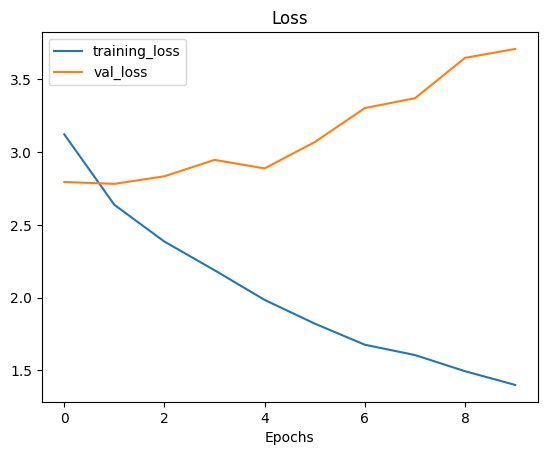

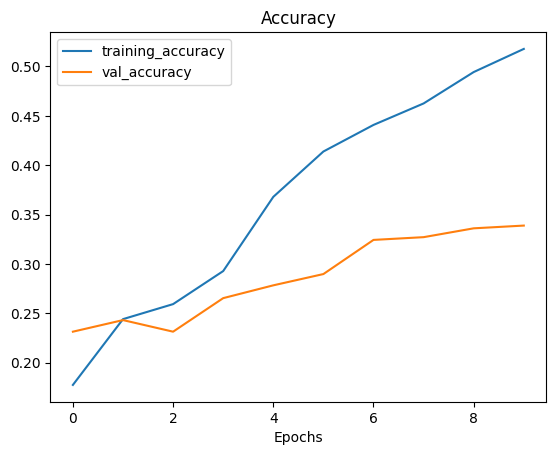

In [ ]:
plot_loss_curves(history_big3)

## Comparing Histories

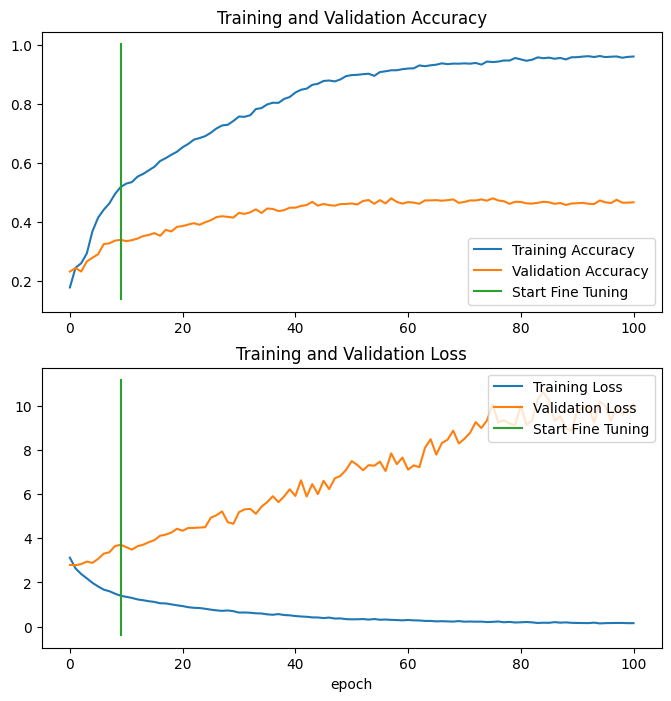

In [ ]:
compare_historys(history_big3,
                 new_history_big2,
                 initial_epochs=10)

# Modelling 4

In [ ]:
CLASSES = len(y.unique())
CLASSES

59

In [ ]:
def acc(y_test, y_preds):
  model_preds = y_preds
  return tf.reduce_mean(tf.cast(tf.argmax(model_preds, axis=-1) == tf.argmax(y_test, axis=-1), dtype=tf.float32))

def custom_loss(y_test, y_preds):
  return (1.0-acc(y_test, y_preds))

In [ ]:
try:
  del model4
except:
  mb=1
CLASSES = len(y.unique())
do = 0.3
do1 = 0.6
L1 = 0.001
L2 = 0.000001
# 1. tokens
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_token_embed(token_inputs)
token_embeddings = layers.LayerNormalization()(token_embeddings)

# 2. character
char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectorize = char_vectorizer(char_inputs)


# 3. Concatenate-1
char_token_concat = layers.Concatenate(name="token_char_concatenation")([token_embeddings,
                                                                         layers.LayerNormalization()(char_vectorize)])
char_token_concat = layers.Dense(640)(char_token_concat)
drop_char_token = layers.Dropout(do1)(char_token_concat)

# 4. Bi-LSTM to concatenated token char
temb = layers.Reshape((32, 20))(drop_char_token)
value_input_pair = layers.Conv1D(1024, 3, padding='same')(temb)
value_pair = layers.LayerNormalization()(value_input_pair)
value_pair = layers.Conv1D(256, 3, padding='same')(value_pair)

# 5. CNN
text_inputs = layers.Input(shape=(1,), dtype=tf.string, name="custom_token_embedding")
text_vectors_cnn = text_vectorizer(text_inputs)
query_pair = text_embed(text_vectors_cnn)
query_pair = layers.Conv1D(256, 3, padding='same')(query_pair)

# 6. Attention model ([v,q])
self_attention = tf.keras.layers.MultiHeadAttention(
    num_heads=1024, key_dim=2, value_dim=2
)(query_pair, value_pair)


self_attention = layers.GlobalAveragePooling1D()(self_attention)
query_encoding = layers.GlobalAveragePooling1D()(query_pair)
x1 = layers.Concatenate()([query_encoding, self_attention])

# x1 = layers.Concatenate()([query_pair, self_attention])
# x1 = layers.Concatenate()([query_pair, value_pair])
# x1 = layers.GlobalAveragePooling1D()(x1)
x1 = layers.LayerNormalization()(x1)

x2 = layers.Dense(256
                  # , 3, padding='same'
                  )(x1)

x3 = layers.ActivityRegularization(l1 = L1, l2 = L2)(x2)

x5 = layers.Dense(CLASSES*2,
                  # , 3, activation='relu', padding='same'
                  )(x3)
x5 = layers.ActivityRegularization(l1 = L1, l2 = L2)(x5)
x5 = layers.Dropout(do1)(x5)

output_layer = layers.Dense(CLASSES, activation="softmax", name='Ouput_layer')(x5)


# 12. Modelate
model4 = tf.keras.Model(inputs =[
                                  token_inputs,
                                  text_inputs,
                                  char_inputs
                                ],
                            outputs = output_layer,
                            name="The_Ultimate_Model")
# Compile the model
model4.compile(
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                # loss = custom_loss,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=[acc]
              )

# Get summary
model4.summary()

Model: "The_Ultimate_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 tf_hub_trainable_embedding  (None, 512)                  2567978   ['token_input[0][0]']         
 _layer (KerasLayer)                                      24                                      
                                                                                                  
 character_vectorizer (Text  (None, 230)                  0         ['input_4[0][

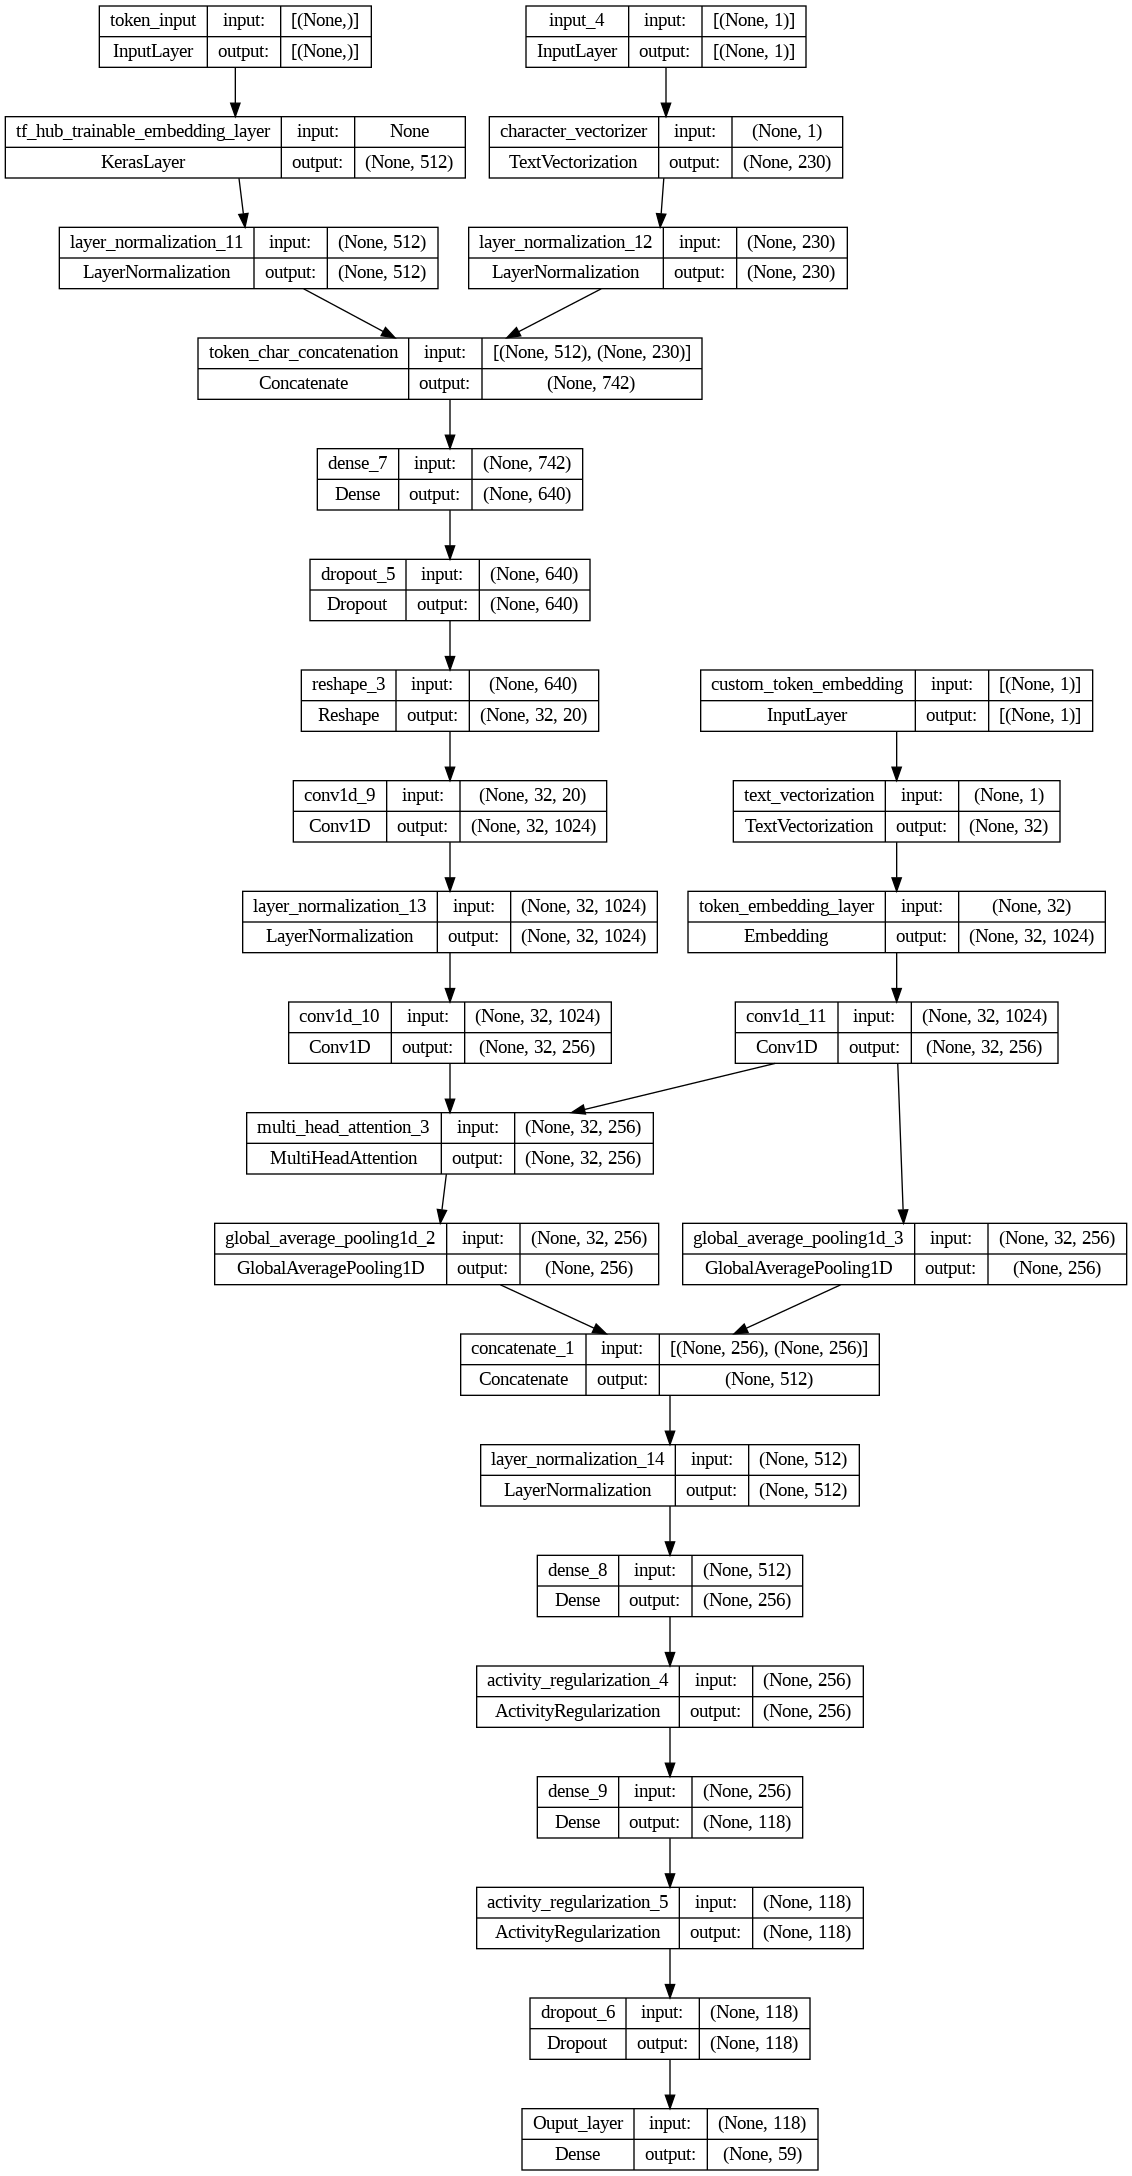

In [ ]:
tf.keras.utils.plot_model(model4, show_shapes=True)

## Dataset creation to tensor slices

In [ ]:
BATCH = 256

In [ ]:
# Get the validing and validation sets ready
# Training Set
training_input_set = tf.data.Dataset.from_tensor_slices((X_train.to_list(), X_train.to_list(), train_chars))
training_output_set = tf.data.Dataset.from_tensor_slices(y_train)
train_data = tf.data.Dataset.zip((training_input_set, training_output_set))
train_data = train_data.batch(BATCH).prefetch(tf.data.AUTOTUNE)

# ?Validation Set
validation_input_set = tf.data.Dataset.from_tensor_slices((X_valid.to_list(), X_valid.to_list(), valid_chars))
validation_output_set = tf.data.Dataset.from_tensor_slices(y_valid)
valid_data = tf.data.Dataset.zip((validation_input_set, validation_output_set))
valid_data = valid_data.batch(BATCH).prefetch(tf.data.AUTOTUNE)

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# Fit the model
import warnings
warnings.filterwarnings('ignore')
tf.random.set_seed(7)
history4 = model4.fit(train_data,
                      epochs=20,
                      steps_per_epoch=len(train_data),
                      validation_data=valid_data,
                      callbacks=[
                                  # tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                  #                                 patience=5),
                                  # cb,
                                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                      patience=2,
                                                                      factor=0.1)
                                ]
                      )

31/31 [==============================] - 16s 348ms/step - loss: 3.5157 - acc: 0.2480 - val_loss: 3.0764 - val_acc: 0.3662 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - 10s 323ms/step - loss: 1.6597 - acc: 0.6271 - val_loss: 2.7088 - val_acc: 0.4996 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - 10s 325ms/step - loss: 0.7713 - acc: 0.8822 - val_loss: 2.7304 - val_acc: 0.5110 - lr: 0.0010
Epoch 4/20
31/31 [==============================] - 10s 324ms/step - loss: 0.4711 - acc: 0.9714 - val_loss: 2.7496 - val_acc: 0.5163 - lr: 0.0010
Epoch 5/20
31/31 [==============================] - 10s 323ms/step - loss: 0.3839 - acc: 0.9900 - val_loss: 2.7021 - val_acc: 0.5184 - lr: 1.0000e-04
Epoch 6/20
31/31 [==============================] - 10s 320ms/step - loss: 0.3644 - acc: 0.9937 - val_loss: 2.6806 - val_acc: 0.5202 - lr: 1.0000e-04
Epoch 7/20
31/31 [==============================] - 10s 318ms/step - loss: 0.3512 - acc: 0.9953 - val_loss: 2.6611 - val_acc: 0

## Plot loss-accuracy curves

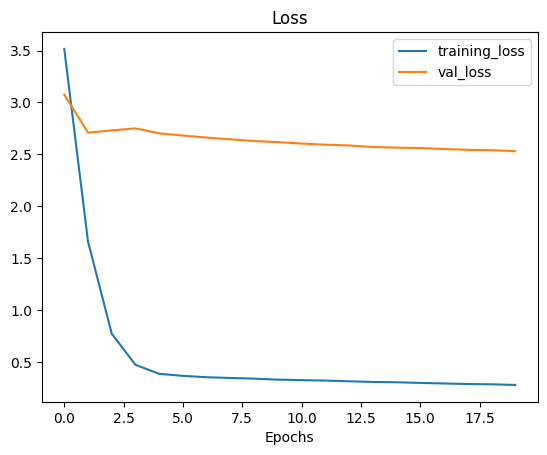

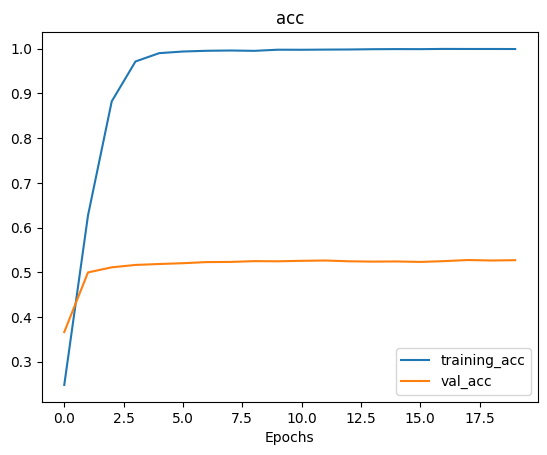

In [ ]:
plot_loss_curves(history4)

In [ ]:
# Fit the model
tf.random.set_seed(7)
history4_1 = model4.fit(train_data,
                      epochs=50,
                      initial_epoch=history4.epoch[-1],
                      steps_per_epoch=len(train_data),
                      validation_data=valid_data,
                      callbacks=[
                                  # tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                  #                                 patience=5),
                                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                      patience=2,
                                                                      factor=0.1)
                                ]
                      )

In [ ]:
# Fit the model
tf.random.set_seed(7)
history4_2 = model4.fit(train_data,
                        epochs=100,
                        initial_epoch=history4_1.epoch[-1],
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        callbacks=[
                                    # tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                    #                                 patience=20),
                                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                        patience=4,
                                                                        factor=0.1)
                                  ]
                      )

In [ ]:
# Fit the model
tf.random.set_seed(7)
history4_3 = model4.fit(train_data,
                        epochs=200,
                        initial_epoch=history4_2.epoch[-1],
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        callbacks=[
                                    # tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                    #                                 patience=20),
                                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                        patience=4,
                                                                        factor=0.1)
                                  ]
                      )

In [ ]:
# Fit the model
tf.random.set_seed(7)
history4_4 = model4.fit(train_data,
                        epochs=500,
                        initial_epoch=history4_3.epoch[-1],
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        callbacks=[
                                    # tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                    #                                 patience=20),
                                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                        patience=4,
                                                                        factor=0.1)
                                  ]
                      )

## Evaluation of results

In [ ]:
# ?Testing Set
testing_input_set = tf.data.Dataset.from_tensor_slices((X_test.to_list(), X_test.to_list(), test_chars))
testing_output_set = tf.data.Dataset.from_tensor_slices(y_test)
test_data = tf.data.Dataset.zip((testing_input_set, testing_output_set))
test_data = test_data.batch(BATCH).prefetch(tf.data.AUTOTUNE)

l, ac = model4.evaluate(test_data, verbose=0)
print(f'loss = {l:.3f} ; accuracy = {ac*100:.2f} %')

loss = 2.480 ; accuracy = 53.95 %


In [ ]:
model_preds = model4.predict(test_data, verbose=0)

In [ ]:
y.unique()

array(['Tampa', 'Cleveland', 'Bay Lake', 'Arlington',
       'Indianapolis city balance', 'Detroit', 'Raleigh', 'San Antonio',
       'Seattle', 'Kansas City', 'Long Beach',
       'NashvilleDavidson metropolitan government balance', 'Albuquerque',
       'Portland', 'Minneapolis', 'Denver', 'Orlando', 'El Paso',
       'Las Vegas', 'Paradise', 'Santa Monica', 'Baltimore',
       'Virginia Beach', 'Pittsburgh', 'Sacramento', 'Phoenix', 'Oakland',
       'Jacksonville', 'Huntington Beach', 'Memphis', 'Columbus',
       'West Hollywood', 'Charlotte', 'Richmond', 'Burbank',
       'New Orleans', 'Newark', 'Miami Beach', 'Beverly Hills',
       'San Jose', 'Boston', 'Oklahoma City', 'Wilmington', 'Tucson',
       'Louisville', 'Fort Lauderdale', 'St Louis', 'Salt Lake City',
       'Milwaukee', 'Scottsdale', 'Greensboro', 'Fort Worth', 'Columbia',
       'Anaheim', 'Henderson', 'Charleston', 'Jersey City', 'Pasadena',
       'Cincinnati'], dtype=object)

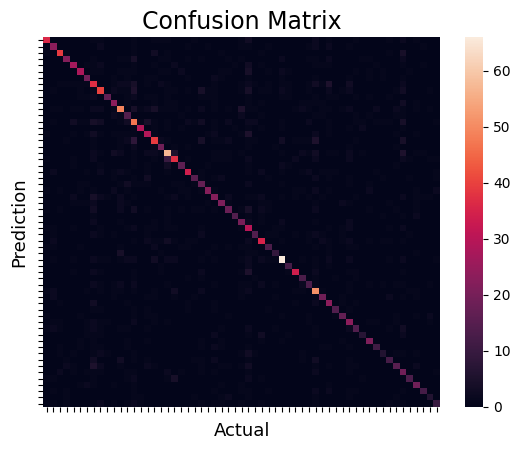

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Create the NumPy array for actual and predicted labels.
actual    = np.array(tf.argmax(y_test, axis=-1))
predicted = np.array(tf.argmax(model_preds, axis=-1))

#compute the confusion matrix.
cm = confusion_matrix(actual,predicted)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=False,
            fmt='g',
            xticklabels=['' for i in range(CLASSES)],
            yticklabels=['' for i in range(CLASSES)])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

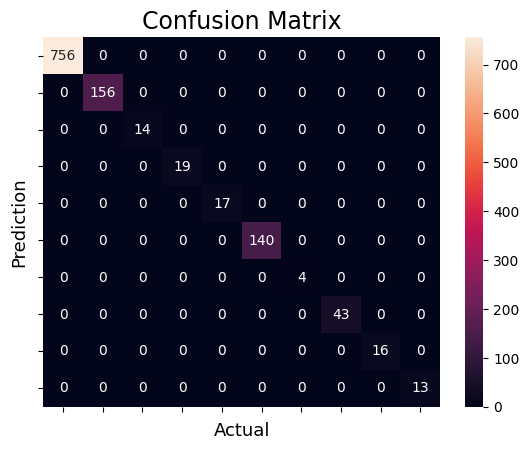

In [ ]:
#Plot the confusion matrix.
sns.heatmap(cm[:10, :10],
            annot=True,
            fmt='g',
            xticklabels=['' for i in range(10)],
            yticklabels=['' for i in range(10)])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
model_preds = model4.predict(valid_data)

12/12 [==============================] - 24s 2s/step


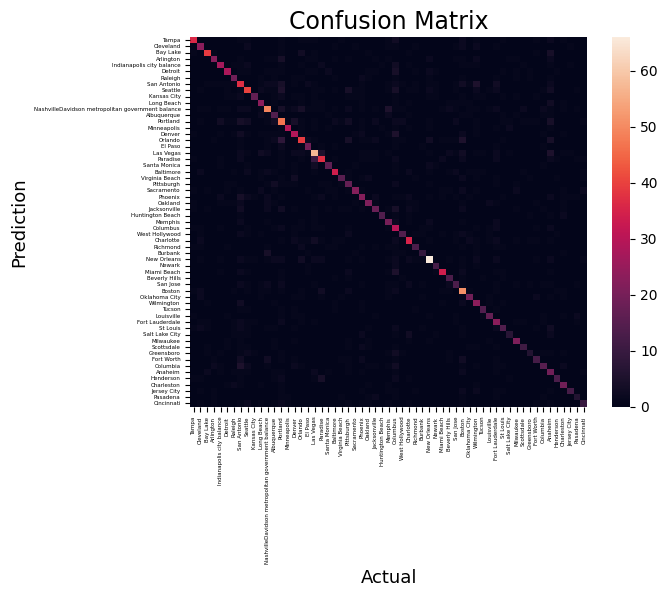

In [ ]:
actual    = np.array(tf.argmax(y_test, axis=-1))
predicted = np.array(tf.argmax(model_preds, axis=-1))

#compute the confusion matrix.
cm = confusion_matrix(actual,predicted)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=False,
            fmt='g',
            xticklabels=[i for i in y.unique()],
            yticklabels=[i for i in y.unique()])
plt.yticks(fontsize=4)
plt.xticks(fontsize=4)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

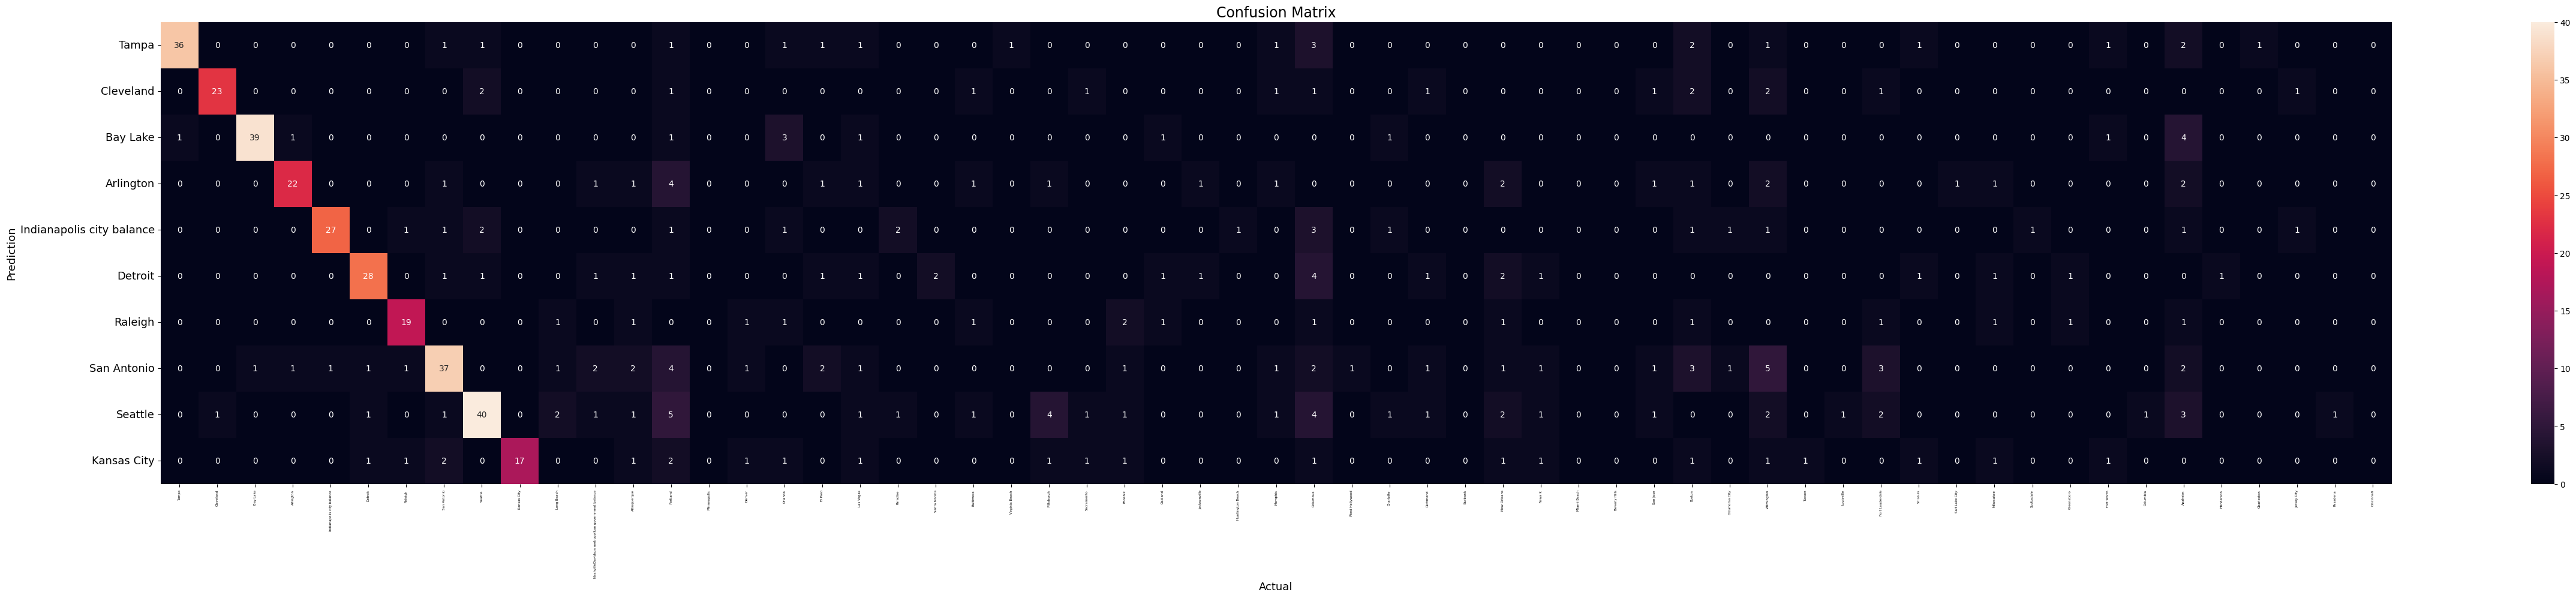

In [ ]:
plt.rcParams['figure.figsize'] = (60, 10)

#Plot the confusion matrix.
sns.heatmap(cm[:10],
            annot=True,
            fmt='g',
            xticklabels=[i for i in y.unique()],
            yticklabels=[i for i in y.unique()[:10]])
plt.yticks(fontsize=13)
plt.xticks(fontsize=4)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
len(np.unique(predicted)), len(np.unique(actual)), actual.dtype

(59, 59, dtype('int64'))

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(actual, predicted,
                            labels=[i for i in range(len(y.unique()))],
                            target_names=[i for i in y.unique()],
                            output_dict=True)
print(classification_report(actual, predicted,
                            labels=[i for i in range(len(y.unique()))],
                            target_names=[i for i in y.unique()]))

                                                   precision    recall  f1-score   support

                                            Tampa       0.75      0.65      0.70        55
                                        Cleveland       0.52      0.61      0.56        38
                                         Bay Lake       0.78      0.74      0.76        53
                                        Arlington       0.71      0.49      0.58        45
                        Indianapolis city balance       0.61      0.59      0.60        46
                                          Detroit       0.68      0.55      0.61        51
                                          Raleigh       0.56      0.56      0.56        34
                                      San Antonio       0.36      0.47      0.41        78
                                          Seattle       0.53      0.49      0.51        82
                                      Kansas City       0.81      0.44      0.57        3

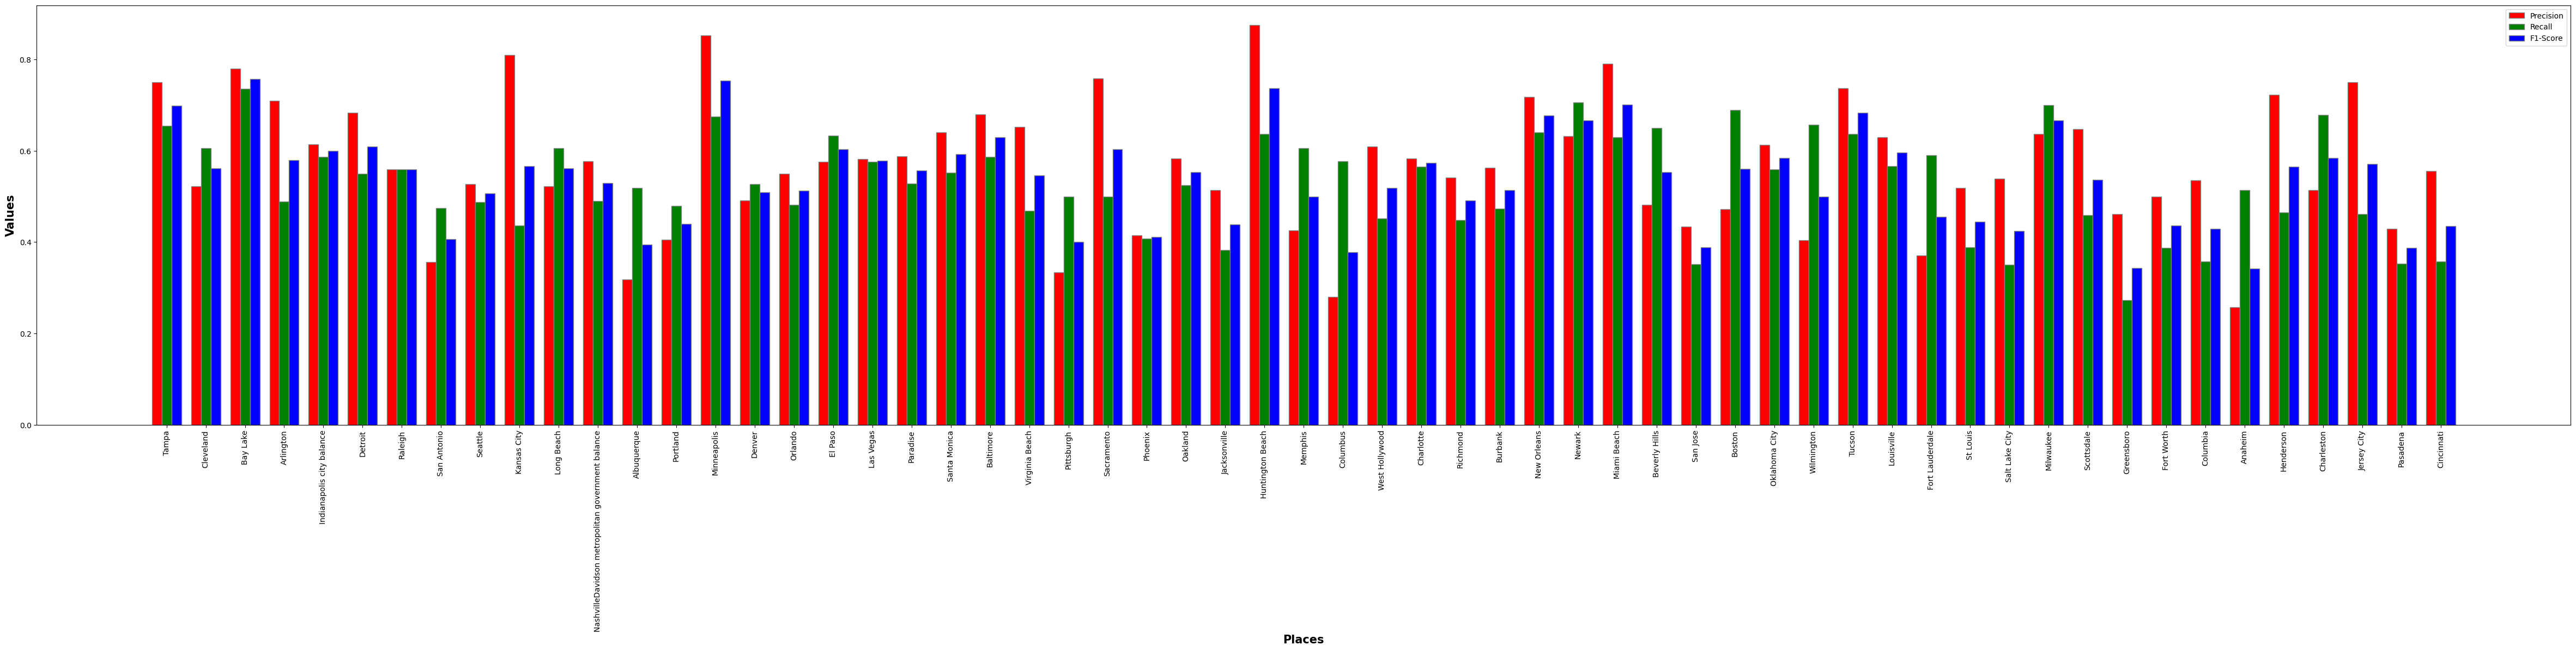

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(60, 10))

# set height of bar
names = []
p = []
r = []
f = []
sp = []
for i,j in cr.items():
  if i == 'accuracy':
    continue
  if i == 'macro avg':
    continue
  if i == 'weighted avg':
    continue

  names.append(i)
  p.append(j['precision'])
  r.append(j['recall'])
  f.append(j['f1-score'])
  sp.append(j['support'])

# Set position of bar on X axis
br1 = np.arange(len(names))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, p, color ='r', width = barWidth,
		edgecolor ='grey', label ='Precision')
plt.bar(br2, r, color ='g', width = barWidth,
		edgecolor ='grey', label ='Recall')
plt.bar(br3, f, color ='b', width = barWidth,
		edgecolor ='grey', label ='F1-Score')

# Adding Xticks
plt.xlabel('Places', fontweight ='bold', fontsize = 15)
plt.ylabel('Values', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(names))],  names, rotation='vertical')

plt.legend()
plt.show()

In [ ]:
cr_df = pd.DataFrame(cr).T
cr_df['places'] = cr_df.index
cr_df = cr_df[:-3]
res = pd.concat([cr_df['precision'], cr_df['recall'], cr_df['f1-score']])

res_df = pd.DataFrame()
res_df['Places'] = res.index
res_df['Values'] = [j for i, j in res.items()]
res_df['Evaluation_metrics'] = ['precision']*int(len(res)/3) + ['recall']*int(len(res)/3) + ['f1-score']*int(len(res)/3)

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, Tampa to Cincinnati
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   precision  59 non-null     float64
 1   recall     59 non-null     float64
 2   f1-score   59 non-null     float64
 3   support    59 non-null     float64
 4   places     59 non-null     object 
dtypes: float64(4), object(1)
memory usage: 2.8+ KB


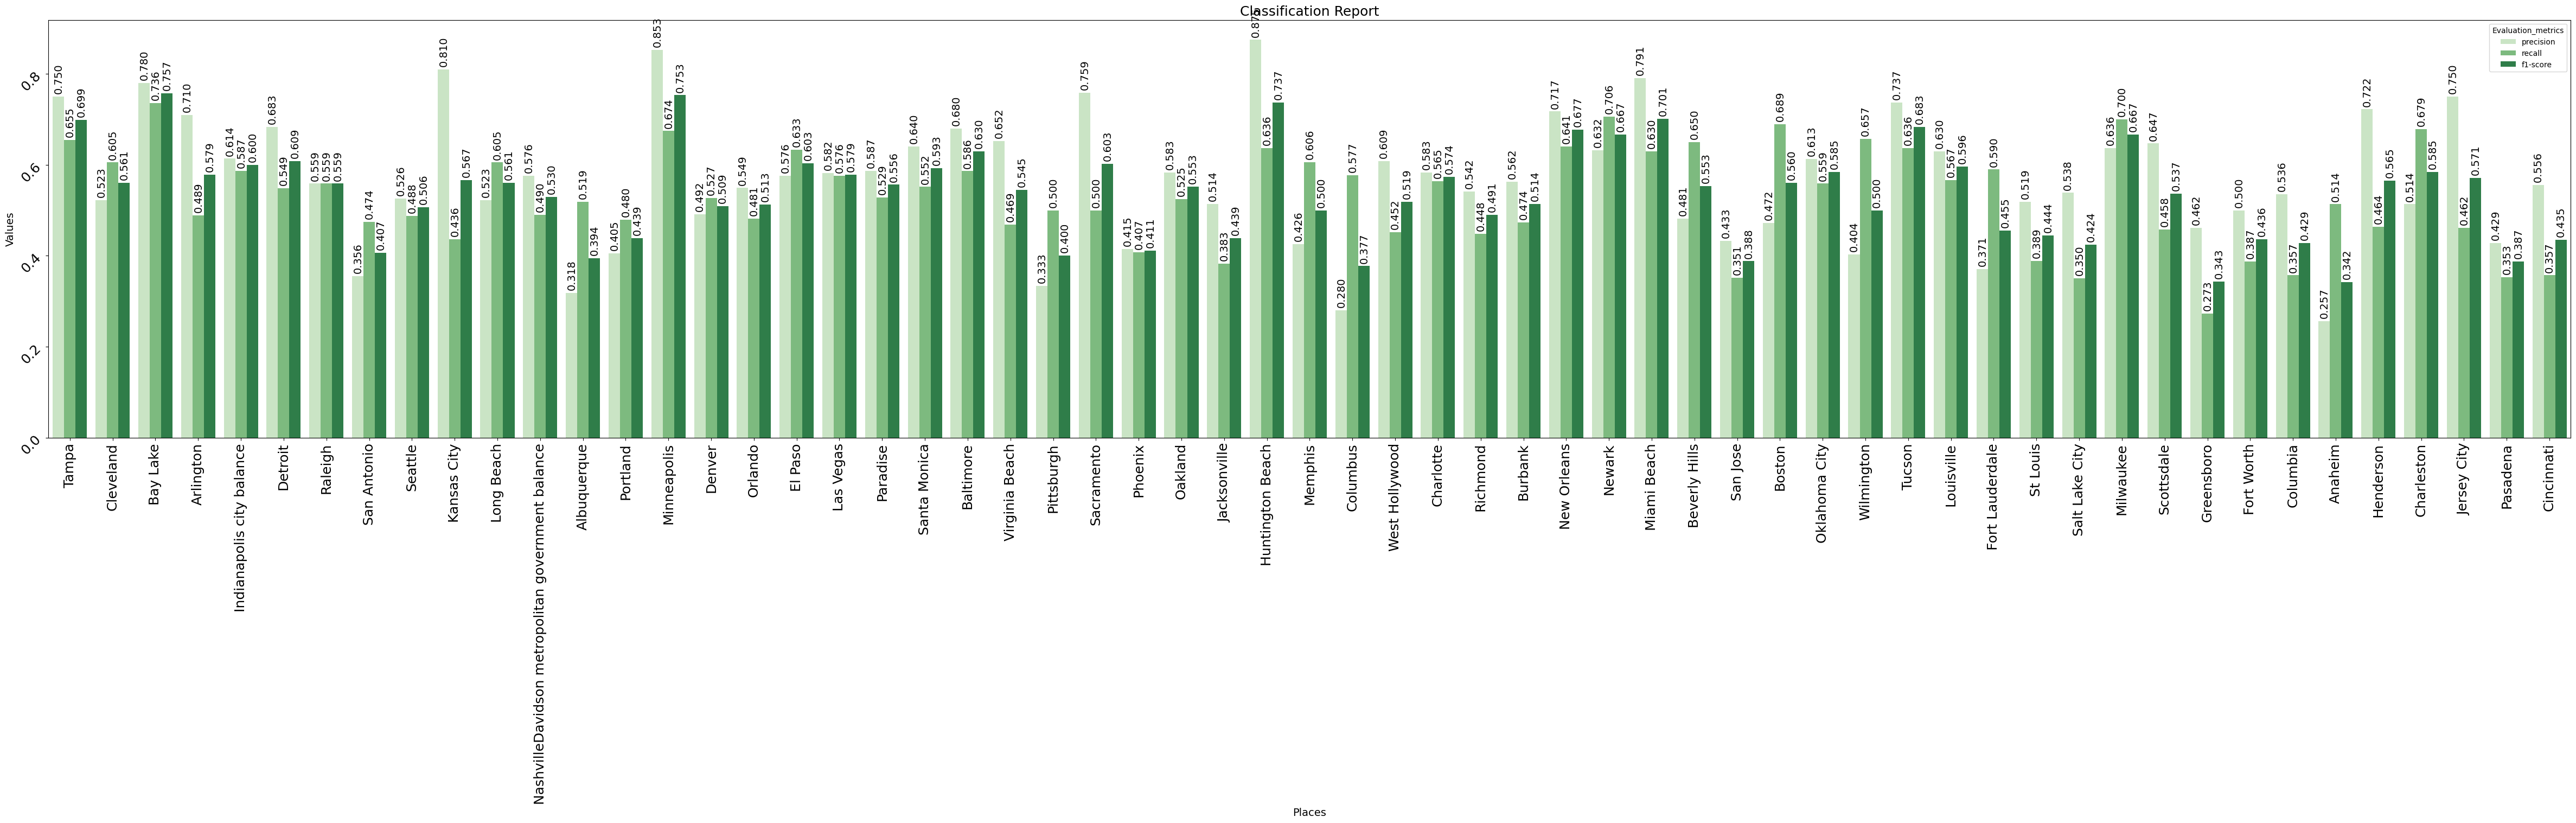

In [ ]:
# code for annotated barplot
plt.figure(figsize=(60, 10))
splot = sns.barplot(x='Places', y='Values', hue="Evaluation_metrics",
					data=res_df, palette='Greens')

plt.ylabel("Values", size=14)
plt.xlabel("Places", size=14)
plt.title("Classification Report", size=18)
plt.xticks(fontsize=18, rotation='vertical')
plt.yticks(fontsize=18, rotation=45)
for p in splot.patches:
	splot.annotate(format(p.get_height(), '.3f'),
				(p.get_x() + p.get_width() / 3., p.get_height()),
				ha='center', va='center',
				size=14,
				xytext=(3, 24),
				textcoords='offset points',
        rotation=90)

In [ ]:
model4.save('/content/drive/MyDrive/GeoData_Extraction/Attention_Model_99.998_percent_acc')

# Individual Layers analysing

In [ ]:
tf.keras.Input(shape=token_embeddings.shape[1:])

<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'input_3')>

In [ ]:
class FullyConnectedLayer(tf.keras.layers.Layer):
  def __init__(self, drop_percent=0.2, l1=0.01, l2=0.01, d1=1000, d2=100, **kwargs):
    super().__init__(**kwargs)
    self.drop_percent = drop_percent
    self.l1=l1
    self.l2=l2
    self.d1=d1
    self.d2=d2
    self.d1r_layer = tf.keras.layers.Dense(d1, activation="relu", name="theta")
    self.d2r_layer = tf.keras.layers.Dense(d2, activation="relu", name="theta")
    self.d1t_layer = tf.keras.layers.Dense(d1, activation="tanh", name="theta")
    self.d2t_layer = tf.keras.layers.Dense(d2, activation="tanh", name="theta")
    self.d1tr_layer = tf.keras.layers.Dense(d1, activation='tanh'
                     ,kernel_regularizer=tf.keras.regularizers.L1(self.l1)
                     ,activity_regularizer=tf.keras.regularizers.L2(self.l2)
                    )
    self.d2tr_layer = tf.keras.layers.Dense(d2, activation='tanh'
                     ,kernel_regularizer=tf.keras.regularizers.L1(self.l1)
                     ,activity_regularizer=tf.keras.regularizers.L2(self.l2)
                    )
    self.d1rr_layer = tf.keras.layers.Dense(d1, activation='relu'
                     ,kernel_regularizer=tf.keras.regularizers.L1(self.l1)
                     ,activity_regularizer=tf.keras.regularizers.L2(self.l2)
                    )
    self.d2rr_layer = tf.keras.layers.Dense(d2, activation='relu'
                     ,kernel_regularizer=tf.keras.regularizers.L1(self.l1)
                     ,activity_regularizer=tf.keras.regularizers.L2(self.l2)
                    )
    self.drop_layer = tf.keras.layers.Dropout(drop_percent)

  def call(self, inputs):

    inpts = inputs
    x  = self.d1r_layer(inpts)
    x1 = self.drop_layer(x)
    x2 = self.d1t_layer(x1)
    x3 = self.drop_layer(x2)
    x4 = self.d1t_layer(x3)

    x5 = self.d2rr_layer(x4)
    x6 = self.drop_layer(x5)
    x7 = self.d2t_layer(x6)

    x8 = self.d2tr_layer(x7)
    output = self.drop_layer(x8)
    return output

class CNN_text_embed(tf.keras.layers.Layer):
  def __init__(self, f_siz=64, k_siz = 5, padding_type='same', d1=64, **kwargs):
    super().__init__(**kwargs)
    self.f_siz = f_siz
    self.k_siz = k_siz
    self.padding_type = padding_type
    self.d1 = d1
    self.conv1d = tf.keras.layers.Conv1D(f_siz, kernel_size=k_siz, padding=padding_type, activation="relu")
    self.globalavgpool = tf.keras.layers.GlobalAveragePooling1D()
    self.d1r_layer = layers.Dense(d1, activation="relu")

  def call(self, cnn_inputs):
    text_vectors_cnn = text_vectorizer(cnn_inputs)
    token_embeddings_cnn = text_embed(text_vectors_cnn)
    x_cnn = self.conv1d(token_embeddings_cnn)
    x_cnn_1 = self.globalavgpool(x_cnn)
    cnn_outputs = self.d1r_layer(x_cnn_1)
    return cnn_outputs

## Char_Token_embed

In [ ]:
try:
  del char_token_embed_model
except:
  mb=1
CLASSES = len(y.unique())

d1 = 1000
d2 = 100
do = 0.2
l1 = 0.01
l2 = 0.01

# 1. tokens
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_token_embed(token_inputs)

xn = FullyConnectedLayer()(token_embeddings)
output_layer = layers.Dense(CLASSES, activation='softmax', name='Ouput_layer')(xn)

# 12. Modelate
char_token_embed_model = tf.keras.Model(inputs = token_inputs,
                                  outputs = output_layer,
                                  name="The_Ultimate_Model")
# Compile the model
char_token_embed_model.compile(loss='CategoricalCrossentropy',
               optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
               metrics=["accuracy"])

# Get summary
char_token_embed_model.summary()

Model: "The_Ultimate_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None,)]                 0         
                                                                 
 tf_hub_trainable_embedding  (None, 512)               256797824 
 _layer (KerasLayer)                                             
                                                                 
 fully_connected_layer (Ful  (None, 100)               1634300   
 lyConnectedLayer)                                               
                                                                 
 Ouput_layer (Dense)         (None, 33)                3333      
                                                                 
Total params: 258435457 (985.85 MB)
Trainable params: 1637633 (6.25 MB)
Non-trainable params: 256797824 (979.61 MB)
________________________________________________________________

In [ ]:
# Get the validing and validation sets ready
# Training Set
training_input_set_ctebed = tf.data.Dataset.from_tensor_slices((X_train.to_list()))
training_output_set_ctebed = tf.data.Dataset.from_tensor_slices(y_train)
train_data_ctebed = tf.data.Dataset.zip((training_input_set_ctebed, training_output_set_ctebed))
train_data_ctebed = train_data_ctebed.batch(32).prefetch(tf.data.AUTOTUNE)

# ?Validation Set
validation_input_set_ctebed = tf.data.Dataset.from_tensor_slices((X_test.to_list()))
validation_output_set_ctebed = tf.data.Dataset.from_tensor_slices(y_test)
valid_data_ctebed = tf.data.Dataset.zip((validation_input_set_ctebed, validation_output_set_ctebed))
valid_data_ctebed = valid_data_ctebed.batch(32).prefetch(tf.data.AUTOTUNE)

# Fit the data
history_ctebed = char_token_embed_model.fit(train_data_ctebed,
    epochs=100,
    steps_per_epoch=len(train_data_ctebed),
    validation_data=valid_data_ctebed,
    validation_steps=len(valid_data_ctebed),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=10)])

Epoch 1/100
246/246 [==============================] - 12s 36ms/step - loss: 47.7414 - accuracy: 0.1583 - val_loss: 46.3641 - val_accuracy: 0.2281
Epoch 2/100
246/246 [==============================] - 4s 17ms/step - loss: 45.0402 - accuracy: 0.2241 - val_loss: 43.7074 - val_accuracy: 0.2281
Epoch 3/100
246/246 [==============================] - 4s 16ms/step - loss: 42.4352 - accuracy: 0.2239 - val_loss: 41.1505 - val_accuracy: 0.2281
Epoch 4/100
246/246 [==============================] - 6s 23ms/step - loss: 39.9306 - accuracy: 0.2239 - val_loss: 38.6930 - val_accuracy: 0.2281
Epoch 5/100
246/246 [==============================] - 5s 22ms/step - loss: 37.5266 - accuracy: 0.2239 - val_loss: 36.3352 - val_accuracy: 0.2281
Epoch 6/100
246/246 [==============================] - 5s 22ms/step - loss: 35.2173 - accuracy: 0.2239 - val_loss: 34.0758 - val_accuracy: 0.2281
Epoch 7/100
246/246 [==============================] - 5s 20ms/step - loss: 33.0086 - accuracy: 0.2239 - val_loss: 31.9104 

### Loss curve analysis

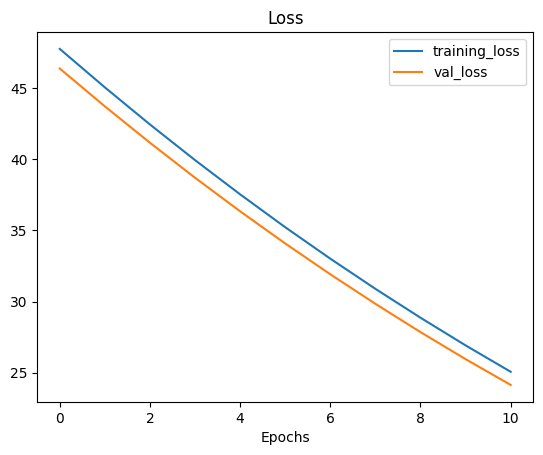

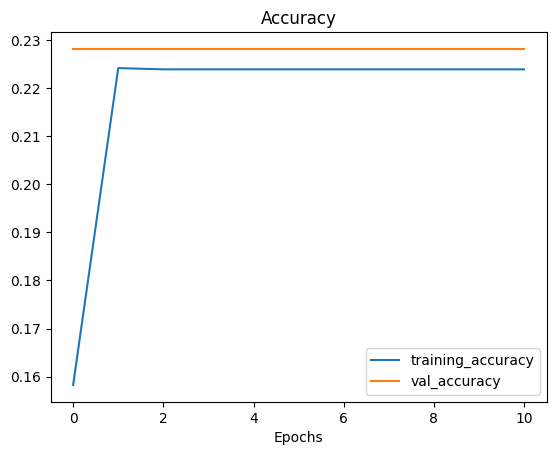

In [ ]:
from helper_functions import *
plot_loss_curves(history_ctebed)

### More training

## Char_BILSTM

In [ ]:
try:
  del model_char_bilstm_model
except:
  mb=1
CLASSES = len(y.unique())

char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectorize = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectorize)
char_bi_lstm = layers.Bidirectional(layers.LSTM(256), name="biLSTM")(char_embeddings)

xn = FullyConnectedLayer(0.2, 0.01, 0.01, 1000, 100)(char_bi_lstm)
output_layer = layers.Dense(CLASSES, activation='softmax', name='Ouput_layer')(xn)

model_char_bilstm_model = tf.keras.Model(inputs = char_inputs,
                            outputs = output_layer,
                            name="The_Ultimate_Model")
# Compile the model
model_char_bilstm_model.compile(loss='CategoricalCrossentropy',
               optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
               metrics=["accuracy"])

# Get summary
model_char_bilstm_model.summary()

Model: "The_Ultimate_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1)]               0         
                                                                 
 character_vectorizer (Text  (None, 228)               0         
 Vectorization)                                                  
                                                                 
 character_embedding_layer   (None, 228, 25)           1600      
 (Embedding)                                                     
                                                                 
 biLSTM (Bidirectional)      (None, 512)               577536    
                                                                 
 fully_connected_layer_2 (F  (None, 100)               1634300   
 ullyConnectedLayer)                                             
                                                

In [ ]:
# Get the validing and validation sets ready
# Training Set
training_input_set_char = tf.data.Dataset.from_tensor_slices((train_chars))
training_output_set_char = tf.data.Dataset.from_tensor_slices(y_train)
train_data_char = tf.data.Dataset.zip((training_input_set_char, training_output_set_char))
train_data_char = train_data_char.batch(32).prefetch(tf.data.AUTOTUNE)

# ?Validation Set
validation_input_set_char = tf.data.Dataset.from_tensor_slices((valid_chars))
validation_output_set_char = tf.data.Dataset.from_tensor_slices(y_test)
valid_data_char = tf.data.Dataset.zip((validation_input_set_char, validation_output_set_char))
valid_data_char = valid_data_char.batch(32).prefetch(tf.data.AUTOTUNE)

# Fit the data
history_chr_embed = model_char_bilstm_model.fit(train_data_char,
    epochs=100,
    steps_per_epoch=len(train_data_char),
    validation_data=valid_data_char,
    validation_steps=len(valid_data_char),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=20)])

Epoch 1/100
246/246 [==============================] - 17s 45ms/step - loss: 47.7041 - accuracy: 0.2174 - val_loss: 46.3206 - val_accuracy: 0.2281
Epoch 2/100
246/246 [==============================] - 12s 49ms/step - loss: 44.9955 - accuracy: 0.2239 - val_loss: 43.6632 - val_accuracy: 0.2281
Epoch 3/100
246/246 [==============================] - 8s 32ms/step - loss: 42.3926 - accuracy: 0.2239 - val_loss: 41.1077 - val_accuracy: 0.2281
Epoch 4/100
246/246 [==============================] - 7s 30ms/step - loss: 39.8898 - accuracy: 0.2239 - val_loss: 38.6549 - val_accuracy: 0.2281
Epoch 5/100
246/246 [==============================] - 8s 33ms/step - loss: 37.4953 - accuracy: 0.2239 - val_loss: 36.3053 - val_accuracy: 0.2281
Epoch 6/100
246/246 [==============================] - 7s 29ms/step - loss: 35.1943 - accuracy: 0.2239 - val_loss: 34.0524 - val_accuracy: 0.2281
Epoch 7/100
246/246 [==============================] - 8s 33ms/step - loss: 32.9869 - accuracy: 0.2239 - val_loss: 31.8894

### Loss curve analysis

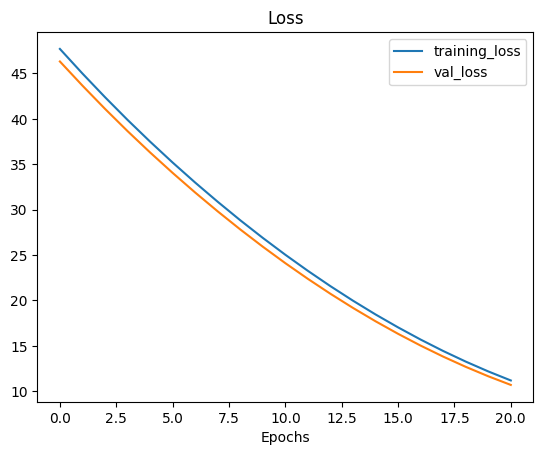

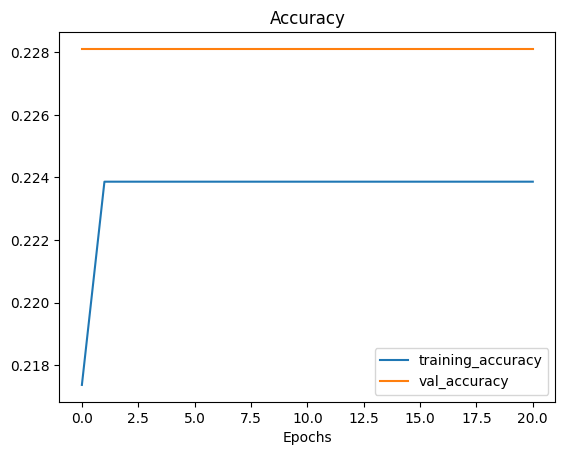

In [ ]:
plot_loss_curves(history_chr_embed)

### More training

## CNN model

In [ ]:
try:
  del model_cnn
except:
  mb=1
CLASSES = len(y.unique())

cnn_inputs = layers.Input(shape=(1,), dtype=tf.string, name="custom_token_embedding")
cnn_outputs = CNN_text_embed()(cnn_inputs)

x = FullyConnectedLayer()(cnn_outputs)
output_layer = layers.Dense(CLASSES, activation='softmax', name='Ouput_layer')(x)


model_cnn = tf.keras.Model(inputs = cnn_inputs,
                        outputs = output_layer,
                        name="The_Ultimate_Model")

model_cnn.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),  metrics=["accuracy"])
model_cnn.summary()

Model: "The_Ultimate_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_token_embedding (In  [(None, 1)]               0         
 putLayer)                                                       
                                                                 
 cnn_text_embed (CNN_text_e  (None, 64)                331904    
 mbed)                                                           
                                                                 
 fully_connected_layer_3 (F  (None, 100)               1186300   
 ullyConnectedLayer)                                             
                                                                 
 Ouput_layer (Dense)         (None, 33)                3333      
                                                                 
Total params: 1521537 (5.80 MB)
Trainable params: 1521537 (5.80 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [ ]:
# Get the validing and validation sets ready
# Training Set
training_input_set_cnn = tf.data.Dataset.from_tensor_slices((X_train.to_list()))
training_output_set_cnn = tf.data.Dataset.from_tensor_slices(y_train)
train_data_cnn = tf.data.Dataset.zip((training_input_set_cnn, training_output_set_cnn))
train_data_cnn = train_data_cnn.batch(32).prefetch(tf.data.AUTOTUNE)

# ?Validation Set
validation_input_set_cnn = tf.data.Dataset.from_tensor_slices((X_test.to_list()))
validation_output_set_cnn = tf.data.Dataset.from_tensor_slices(y_test)
valid_data_cnn = tf.data.Dataset.zip((validation_input_set_cnn, validation_output_set_cnn))
valid_data_cnn = valid_data_cnn.batch(32).prefetch(tf.data.AUTOTUNE)

# Fit the data
history_cnn = model_cnn.fit(train_data_cnn,
    epochs=100,
    steps_per_epoch=len(train_data_cnn),
    validation_data=valid_data_cnn,
    validation_steps=len(valid_data_cnn),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=20)])

Epoch 1/100
246/246 [==============================] - 5s 10ms/step - loss: 47.6676 - accuracy: 0.2113 - val_loss: 46.2921 - val_accuracy: 0.2281
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 44.9744 - accuracy: 0.2237 - val_loss: 43.6446 - val_accuracy: 0.2281
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 42.3766 - accuracy: 0.2239 - val_loss: 41.0916 - val_accuracy: 0.2281
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 39.8761 - accuracy: 0.2239 - val_loss: 38.6350 - val_accuracy: 0.2281
Epoch 5/100
246/246 [==============================] - 3s 12ms/step - loss: 37.4696 - accuracy: 0.2239 - val_loss: 36.2747 - val_accuracy: 0.2281
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 35.1626 - accuracy: 0.2239 - val_loss: 34.0134 - val_accuracy: 0.2281
Epoch 7/100
246/246 [==============================] - 2s 8ms/step - loss: 32.9498 - accuracy: 0.2239 - val_loss: 31.8497 - val_

### Plot loss curves

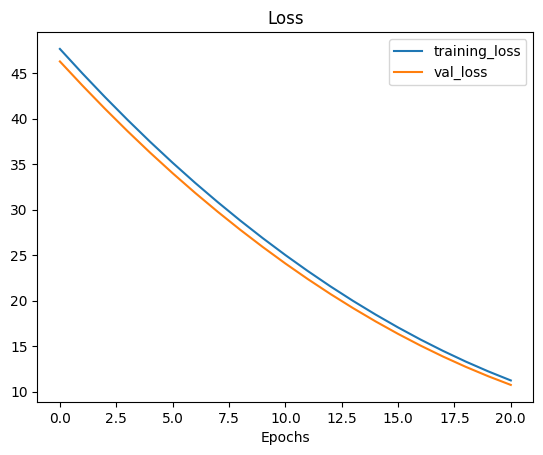

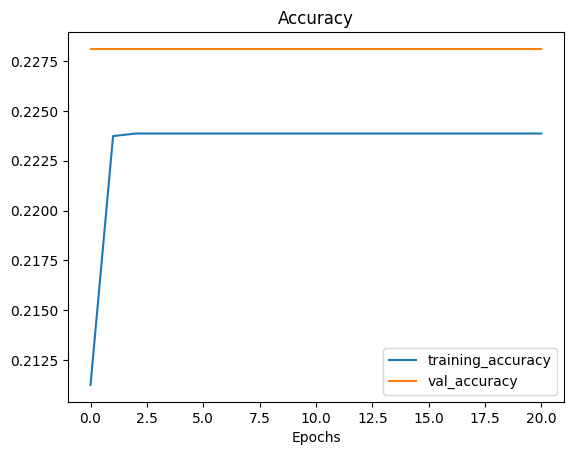

In [ ]:
plot_loss_curves(history_cnn)

# BERT Model

In [ ]:
# Tokenize input statements with BERT model
preprocessor = hub.KerasLayer(
     "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3",
     trainable=False,
     name="Token_embedding_BERT")

In [ ]:
X_train[:1]

10234    To see this smile made everything worth it #hb...
Name: text, dtype: object

In [ ]:
preprocessor(X_train[:1])['input_word_ids']

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  2000,  2156,  2023,  2868,  2081,  2673,  4276,  2009,
         1001,  1044,  2497,  2094,  1030, 13057,  3516, 16770, 13535,
         8913,  2683,  2015,  2615, 21600, 20492,  2487,  4160,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [ ]:
try:
  del model_bert
except:
  c = 1
tf.random.set_seed(42)
CLASS = len(y.unique())

text_input = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = preprocessor(text_input)['input_word_ids']
x = tf.keras.layers.LayerNormalization()(tf.cast(token_embeddings, dtype=tf.float32))
x = tf.keras.layers.Dense(1024, activation='tanh')(x)
# Stacked LSTM layers
# LSTM_layer1 = layers.Bidirectional(layers.LSTM(16, return_sequences=False))(tf.expand_dims(x, axis=1))

outputs = layers.Dense(CLASS, activation='sigmoid', name='Ouput_layer')(x)

model_bert = tf.keras.Model(inputs = text_input,
                       outputs = outputs,
                       name="The_Location_Extraction_BERT_Model")

model_bert.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[acc])

In [ ]:
# Summary of model
model_bert.summary()

Model: "The_Location_Extraction_BERT_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_input (InputLayer)    [(None,)]                 0         
                                                                 
 Token_embedding_BERT (Kera  {'input_word_ids': (Non   0         
 sLayer)                     e, 128),                            
                              'input_mask': (None, 1             
                             28),                                
                              'input_type_ids': (Non             
                             e, 128)}                            
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 128)               0         
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                 

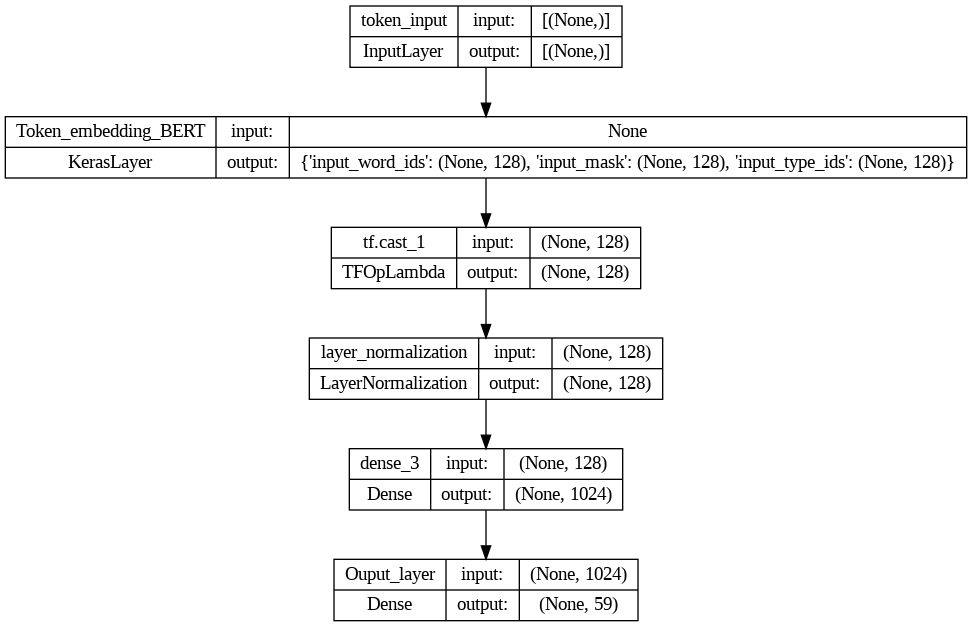

In [ ]:
# Model diagram
from tensorflow.keras.utils import plot_model
plot_model(model_bert, show_shapes=True)

In [ ]:
# Get the validing and validation sets ready
# Training Set
training_input_set = tf.data.Dataset.from_tensor_slices((X_train.to_list()))
training_output_set = tf.data.Dataset.from_tensor_slices(y_train)
train_data = tf.data.Dataset.zip((training_input_set, training_output_set))
train_data = train_data.batch(32)#.prefetch(tf.data.AUTOTUNE)

# ?Validation Set
validation_input_set = tf.data.Dataset.from_tensor_slices((X_valid.to_list()))
validation_output_set = tf.data.Dataset.from_tensor_slices(y_valid)
valid_data = tf.data.Dataset.zip((validation_input_set, validation_output_set))
valid_data = valid_data.batch(32)#.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit the model
tf.random.set_seed(42)
history_bert = model_bert.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data)
                    # callbacks=[create_tensorboard_callback(DIR, EXP)]
                    )

Epoch 1/10
242/242 [==============================] - 4s 12ms/step - loss: 0.0974 - acc: 0.0328 - val_loss: 0.0885 - val_acc: 0.0278
Epoch 2/10
242/242 [==============================] - 3s 11ms/step - loss: 0.0863 - acc: 0.0391 - val_loss: 0.0892 - val_acc: 0.0270
Epoch 3/10
242/242 [==============================] - 5s 21ms/step - loss: 0.0853 - acc: 0.0444 - val_loss: 0.0894 - val_acc: 0.0278
Epoch 4/10
242/242 [==============================] - 3s 11ms/step - loss: 0.0847 - acc: 0.0470 - val_loss: 0.0895 - val_acc: 0.0305
Epoch 5/10
242/242 [==============================] - 5s 19ms/step - loss: 0.0841 - acc: 0.0497 - val_loss: 0.0896 - val_acc: 0.0297
Epoch 6/10
242/242 [==============================] - 4s 15ms/step - loss: 0.0836 - acc: 0.0518 - val_loss: 0.0896 - val_acc: 0.0293
Epoch 7/10
242/242 [==============================] - 3s 11ms/step - loss: 0.0832 - acc: 0.0541 - val_loss: 0.0896 - val_acc: 0.0289
Epoch 8/10
242/242 [==============================] - 4s 15ms/step - 

In [ ]:
# Fit the model
tf.random.set_seed(42)
history_bert = model_bert.fit(train_data,
                    epochs=50,
                    initial_epoch=history_bert.epoch[-1],
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data)
                    # callbacks=[create_tensorboard_callback(DIR, EXP)]
                    )

Epoch 10/50
242/242 [==============================] - 3s 12ms/step - loss: 0.0816 - acc: 0.0651 - val_loss: 0.0898 - val_acc: 0.0285
Epoch 11/50
242/242 [==============================] - 5s 23ms/step - loss: 0.0810 - acc: 0.0704 - val_loss: 0.0899 - val_acc: 0.0301
Epoch 12/50
242/242 [==============================] - 4s 17ms/step - loss: 0.0804 - acc: 0.0766 - val_loss: 0.0901 - val_acc: 0.0312
Epoch 13/50
242/242 [==============================] - 4s 17ms/step - loss: 0.0797 - acc: 0.0841 - val_loss: 0.0903 - val_acc: 0.0309
Epoch 14/50
242/242 [==============================] - 3s 14ms/step - loss: 0.0787 - acc: 0.0934 - val_loss: 0.0905 - val_acc: 0.0328
Epoch 15/50
242/242 [==============================] - 3s 11ms/step - loss: 0.0776 - acc: 0.1056 - val_loss: 0.0909 - val_acc: 0.0324
Epoch 16/50
242/242 [==============================] - 4s 17ms/step - loss: 0.0763 - acc: 0.1198 - val_loss: 0.0912 - val_acc: 0.0343
Epoch 17/50
242/242 [==============================] - 3s 14ms

In [ ]:
# ?testing Set
testing_input_set = tf.data.Dataset.from_tensor_slices((X_test.to_list()))
testing_output_set = tf.data.Dataset.from_tensor_slices(y_test)
test_data = tf.data.Dataset.zip((testing_input_set, testing_output_set))
test_data = test_data.batch(32)

In [ ]:
model_bert.evaluate(test_data)

81/81 [==============================] - 1s 7ms/step - loss: 0.1632 - acc: 0.0307


[0.16315269470214844, 0.030653759837150574]

## Plot loss curves

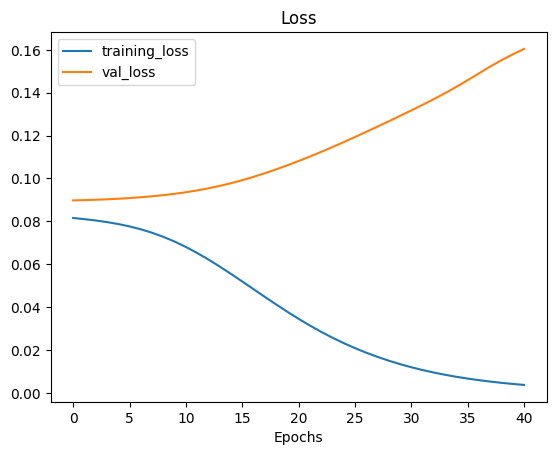

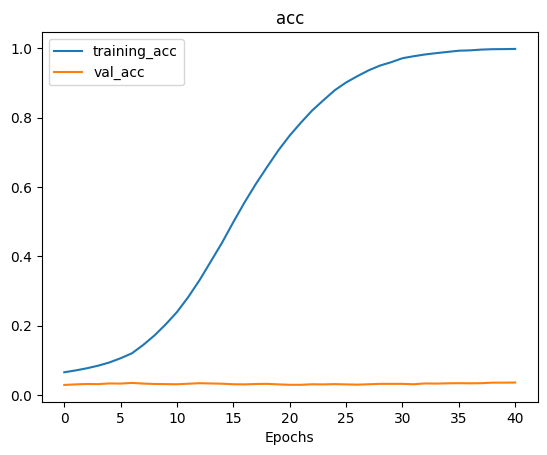

In [ ]:
plot_loss_curves(history_bert)